# Object Detection - Phase 2 Computer Vision





#### Omar Mohamed Lotfy  18P5606
#### Nour El-Din Mohamed 18P5806

## Importing Libraries

In [1]:
import numpy as np
import time 
import cv2
import os 
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

## Load Yolo Weights/ CFG 

In [2]:
# weights contain the resulted weights from the pretrained model
# CFG contained neural network architecture
weights_path = os.path.join("yolo","yolov3.weights")
Cfg_Path = os.path.join("yolo","yolov3.cfg")

## Load Neural Net 

In [3]:
#Save The Neural Networj in a variable
net =cv2.dnn.readNetFromDarknet(Cfg_Path,weights_path)

## Show Layers Names

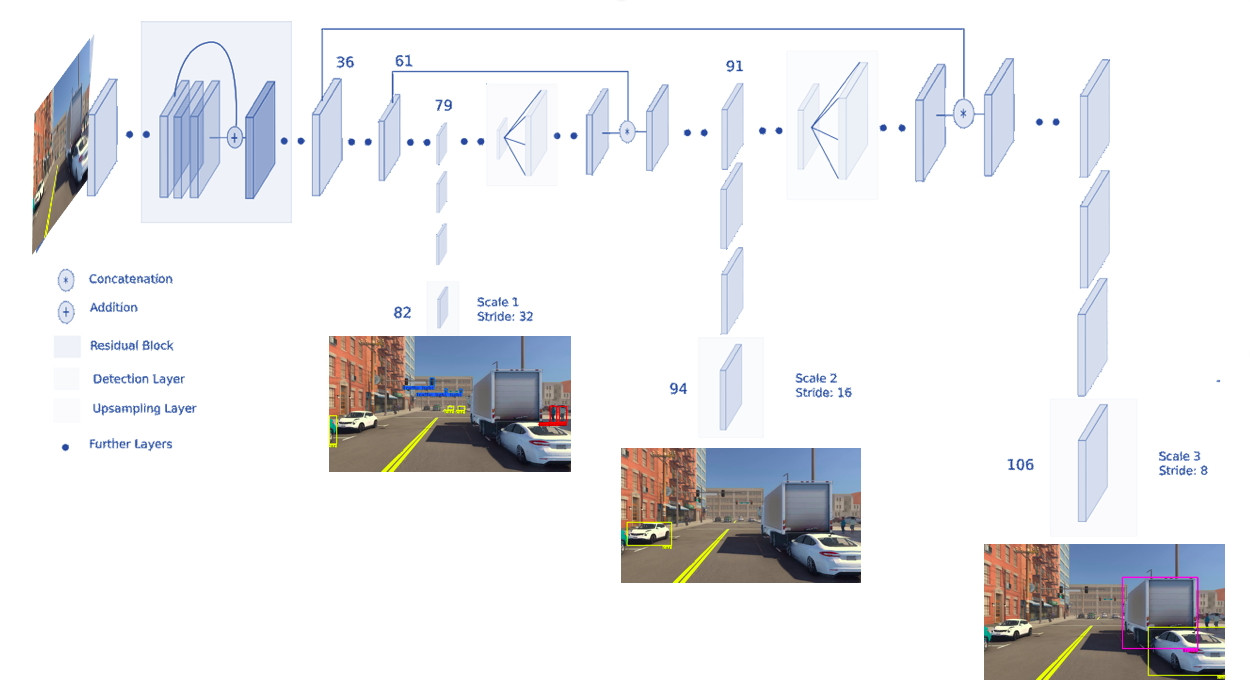

In [4]:
# Get all The Layer names from yolov3 architecture
names = net.getLayerNames()

In [5]:
names

('conv_0',
 'bn_0',
 'leaky_1',
 'conv_1',
 'bn_1',
 'leaky_2',
 'conv_2',
 'bn_2',
 'leaky_3',
 'conv_3',
 'bn_3',
 'leaky_4',
 'shortcut_4',
 'conv_5',
 'bn_5',
 'leaky_6',
 'conv_6',
 'bn_6',
 'leaky_7',
 'conv_7',
 'bn_7',
 'leaky_8',
 'shortcut_8',
 'conv_9',
 'bn_9',
 'leaky_10',
 'conv_10',
 'bn_10',
 'leaky_11',
 'shortcut_11',
 'conv_12',
 'bn_12',
 'leaky_13',
 'conv_13',
 'bn_13',
 'leaky_14',
 'conv_14',
 'bn_14',
 'leaky_15',
 'shortcut_15',
 'conv_16',
 'bn_16',
 'leaky_17',
 'conv_17',
 'bn_17',
 'leaky_18',
 'shortcut_18',
 'conv_19',
 'bn_19',
 'leaky_20',
 'conv_20',
 'bn_20',
 'leaky_21',
 'shortcut_21',
 'conv_22',
 'bn_22',
 'leaky_23',
 'conv_23',
 'bn_23',
 'leaky_24',
 'shortcut_24',
 'conv_25',
 'bn_25',
 'leaky_26',
 'conv_26',
 'bn_26',
 'leaky_27',
 'shortcut_27',
 'conv_28',
 'bn_28',
 'leaky_29',
 'conv_29',
 'bn_29',
 'leaky_30',
 'shortcut_30',
 'conv_31',
 'bn_31',
 'leaky_32',
 'conv_32',
 'bn_32',
 'leaky_33',
 'shortcut_33',
 'conv_34',
 'bn_34',
 'l

In [6]:
# get connectedOutLayersNames returns the only the 3 output layers in yolov3 from our saved neural net
# which are yolo_82,yolo_94,yolo_106 in a tuple 
# Then we convert tuple into a list
layers_names = net.getUnconnectedOutLayersNames()
list(layers_names)

['yolo_82', 'yolo_94', 'yolo_106']

# Layers Out Vector

<b>Pc</b> states whether the object is present in the grid or not

<b>bx,by,bh,bw</b> specify the bounding box if there is an object

According To number of classes we add <b>C#</b> in the vector table; one hot encoded(only one class is 1 and others equal 0)

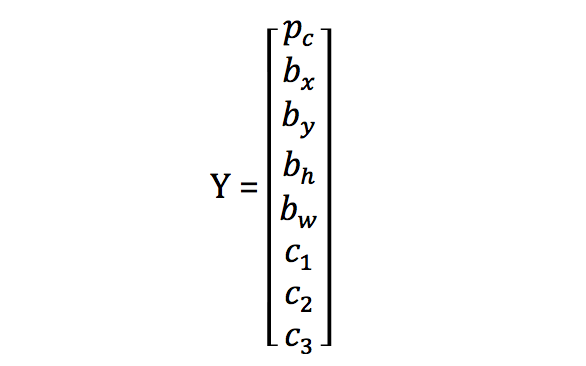

In [7]:
#Get Binary Large Object from img (BLOB) 
#blobFromImage(Img,scale Factor,size,crop,swapRB =true since our image is BGR)
def blobimg(img):
    
    blob = cv2.dnn.blobFromImage(img,1/255.0,(416,416),crop = False, swapRB = True)
    #Input Our Blob into the Neural Net
    net.setInput(blob)
    #start Timer
    start_t=time.time()
    # Forward pass the layers to compute net output returns a np array that will be used to plot box
    layers_out=net.forward(layers_names)
    #show How long did it take
    print("Time To Forward Pass Layers is: {}".format(time.time()-start_t))
    return layers_out



In [8]:
# Function that detects class according to confidence value
# the max score from the output layer is the class we're detecting
def detection_f(layers_out,Height , Width):
    boxes=[]
    confidences=[]
    classIDs=[]
    # Output Counter that contains yolo_82,yolo_94,yolo_106 tuple
    for output in layers_out:
        # Detection counter contain counter that passes through the output_layers iteratively 
        for detection in output:
            # Get the class with the highst score
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence= scores[classID]
            
            # only draw box if confidence is greater than 85%

            if confidence>0.85:
                box = detection[:4] *np.array([Width,Height,Width,Height])
                bx,by,bw,bh=box.astype("int")
                
                # derive the top and left corner
                x=int(bx-(bw/2))
                y=int(by-(bh/2))

                boxes.append([x,y,int(bw),int(bh)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    # perform non maximum suppression            
    indxs=cv2.dnn.NMSBoxes(boxes,confidences,0.8,0.8)
    return indxs, boxes,classIDs,confidences

## Get Labels for detection

In [9]:
# Import Labels from yolo folder
labels_path = os.path.join("yolo","coco.names")
#Clear labels from any spaces and any newlines
labels=open(labels_path).read().strip().split("\n")

In [10]:
# View first 5 labels in coco.names 
labels[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

## Draw Box around Detected Object

In [11]:
# Function that draw box around detected object
def flatten(img,indxs,boxes,classIDs,confidences):
    if len(indxs) > 0:
        for i in indxs.flatten():
            # Get box dimensions and center
            (x,y)=[boxes[i][0],boxes[i][1]]
            (w,h)=[boxes[i][2],boxes[i][3]]

            #Draw Rectangle
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,120,0),2)
            #Put Text above detcted object that contains label and confidence
            cv2.putText(img,"{}: {:0.4f}".format(labels[classIDs[i]],confidences[i]),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,120,0),2)

## Process Image

In [12]:
def process_image(img):
    
 #   img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    Height , Width =img.shape[:2]
    layers_out=blobimg(img)
    indxs, boxes,classIDs,confidences=detection_f(layers_out,Height , Width)
    flatten(img,indxs,boxes,classIDs,confidences)
#    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

## Test On Image

In [13]:
# Import Image
img_path = os.path.join("yolo","test_img.png")

img = cv2.imread(img_path)


Text(0.5, 1.0, 'BGR Image')

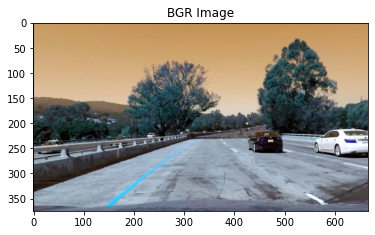

In [14]:
# We will process with BGR Image since we added the parameter swapRB = true in the blob image
plt.imshow(img)
plt.title("BGR Image")

In [15]:
#Write Image
cv2.imwrite("Image.jpg",process_image(img))

Time To Forward Pass Layers is: 2.5762343406677246


True

## Test On video

In [16]:
inputvideo= 'Nissan-test.mp4'
outputvideo= 'Team_vision2.mp4'

myclip = VideoFileClip(inputvideo)
clip = myclip.fl_image(process_image)

%time clip.write_videofile(outputvideo, audio=False)

Time To Forward Pass Layers is: 1.6563072204589844
Moviepy - Building video Team_vision2.mp4.
Moviepy - Writing video Team_vision2.mp4



t:   0%|          | 2/837 [00:02<14:23,  1.03s/it, now=None]

Time To Forward Pass Layers is: 1.9673848152160645


t:   0%|          | 3/837 [00:04<19:35,  1.41s/it, now=None]

Time To Forward Pass Layers is: 1.8329548835754395


t:   0%|          | 4/837 [00:05<21:55,  1.58s/it, now=None]

Time To Forward Pass Layers is: 1.7609918117523193


t:   1%|          | 5/837 [00:08<24:42,  1.78s/it, now=None]

Time To Forward Pass Layers is: 2.0149412155151367


t:   1%|          | 6/837 [00:10<26:10,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.9647026062011719


t:   1%|          | 7/837 [00:12<27:31,  1.99s/it, now=None]

Time To Forward Pass Layers is: 2.106940984725952


t:   1%|          | 8/837 [00:14<26:04,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.5621063709259033


t:   1%|          | 9/837 [00:15<25:39,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.6979362964630127


t:   1%|          | 10/837 [00:17<26:18,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.8960597515106201


t:   1%|▏         | 11/837 [00:19<26:09,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.7660298347473145


t:   1%|▏         | 12/837 [00:21<24:39,  1.79s/it, now=None]

Time To Forward Pass Layers is: 1.4421677589416504


t:   2%|▏         | 13/837 [00:23<25:17,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.8362457752227783


t:   2%|▏         | 14/837 [00:25<27:16,  1.99s/it, now=None]

Time To Forward Pass Layers is: 2.1634626388549805


t:   2%|▏         | 15/837 [00:27<28:36,  2.09s/it, now=None]

Time To Forward Pass Layers is: 2.1784298419952393


t:   2%|▏         | 16/837 [00:30<31:18,  2.29s/it, now=None]

Time To Forward Pass Layers is: 2.524815082550049
Time To Forward Pass Layers is: 2.7346508502960205


t:   2%|▏         | 18/837 [00:35<33:06,  2.43s/it, now=None]

Time To Forward Pass Layers is: 2.122305154800415


t:   2%|▏         | 19/837 [00:37<31:57,  2.34s/it, now=None]

Time To Forward Pass Layers is: 2.052922010421753


t:   2%|▏         | 20/837 [00:40<31:28,  2.31s/it, now=None]

Time To Forward Pass Layers is: 2.0799098014831543


t:   3%|▎         | 21/837 [00:42<31:22,  2.31s/it, now=None]

Time To Forward Pass Layers is: 2.132443904876709


t:   3%|▎         | 22/837 [00:44<31:10,  2.30s/it, now=None]

Time To Forward Pass Layers is: 2.157850742340088


t:   3%|▎         | 23/837 [00:46<30:43,  2.27s/it, now=None]

Time To Forward Pass Layers is: 2.0753636360168457


t:   3%|▎         | 24/837 [00:49<31:06,  2.30s/it, now=None]

Time To Forward Pass Layers is: 2.2477104663848877


t:   3%|▎         | 25/837 [00:51<31:42,  2.34s/it, now=None]

Time To Forward Pass Layers is: 2.2978265285491943


t:   3%|▎         | 26/837 [00:54<33:02,  2.44s/it, now=None]

Time To Forward Pass Layers is: 2.5255637168884277


t:   3%|▎         | 27/837 [00:57<35:18,  2.62s/it, now=None]

Time To Forward Pass Layers is: 2.839759588241577


t:   3%|▎         | 28/837 [01:00<36:46,  2.73s/it, now=None]

Time To Forward Pass Layers is: 2.891432523727417


t:   3%|▎         | 29/837 [01:03<39:12,  2.91s/it, now=None]

Time To Forward Pass Layers is: 3.219770669937134


t:   4%|▎         | 30/837 [01:06<37:49,  2.81s/it, now=None]

Time To Forward Pass Layers is: 2.452089786529541


t:   4%|▎         | 31/837 [01:09<37:24,  2.79s/it, now=None]

Time To Forward Pass Layers is: 2.5620977878570557
Time To Forward Pass Layers is: 3.0684990882873535


t:   4%|▍         | 33/837 [01:14<37:42,  2.81s/it, now=None]

Time To Forward Pass Layers is: 2.3863794803619385


t:   4%|▍         | 34/837 [01:17<36:52,  2.76s/it, now=None]

Time To Forward Pass Layers is: 2.500957727432251


t:   4%|▍         | 35/837 [01:19<32:54,  2.46s/it, now=None]

Time To Forward Pass Layers is: 1.668091058731079


t:   4%|▍         | 36/837 [01:21<30:06,  2.26s/it, now=None]

Time To Forward Pass Layers is: 1.6760435104370117


t:   4%|▍         | 37/837 [01:22<28:15,  2.12s/it, now=None]

Time To Forward Pass Layers is: 1.713437557220459


t:   5%|▍         | 38/837 [01:24<26:15,  1.97s/it, now=None]

Time To Forward Pass Layers is: 1.5311253070831299


t:   5%|▍         | 39/837 [01:26<25:18,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.639538288116455


t:   5%|▍         | 40/837 [01:28<26:30,  2.00s/it, now=None]

Time To Forward Pass Layers is: 2.0823259353637695


t:   5%|▍         | 41/837 [01:30<26:40,  2.01s/it, now=None]

Time To Forward Pass Layers is: 1.8621420860290527


t:   5%|▌         | 42/837 [01:32<27:47,  2.10s/it, now=None]

Time To Forward Pass Layers is: 2.1674351692199707


t:   5%|▌         | 43/837 [01:35<30:24,  2.30s/it, now=None]

Time To Forward Pass Layers is: 2.6225969791412354


t:   5%|▌         | 44/837 [01:38<33:45,  2.55s/it, now=None]

Time To Forward Pass Layers is: 3.0218396186828613


t:   5%|▌         | 45/837 [01:41<33:37,  2.55s/it, now=None]

Time To Forward Pass Layers is: 2.3996715545654297


t:   5%|▌         | 46/837 [01:44<34:54,  2.65s/it, now=None]

Time To Forward Pass Layers is: 2.6881747245788574


t:   6%|▌         | 47/837 [01:47<36:35,  2.78s/it, now=None]

Time To Forward Pass Layers is: 2.9113526344299316


t:   6%|▌         | 48/837 [01:50<37:41,  2.87s/it, now=None]

Time To Forward Pass Layers is: 2.945211887359619


t:   6%|▌         | 49/837 [01:53<38:39,  2.94s/it, now=None]

Time To Forward Pass Layers is: 2.895530939102173


t:   6%|▌         | 50/837 [01:55<35:19,  2.69s/it, now=None]

Time To Forward Pass Layers is: 1.9929754734039307


t:   6%|▌         | 51/837 [01:57<31:50,  2.43s/it, now=None]

Time To Forward Pass Layers is: 1.7049052715301514


t:   6%|▌         | 52/837 [01:59<30:03,  2.30s/it, now=None]

Time To Forward Pass Layers is: 1.8278584480285645


t:   6%|▋         | 53/837 [02:01<30:14,  2.31s/it, now=None]

Time To Forward Pass Layers is: 2.166329860687256


t:   6%|▋         | 54/837 [02:03<29:37,  2.27s/it, now=None]

Time To Forward Pass Layers is: 1.9752447605133057
Time To Forward Pass Layers is: 2.4036548137664795


t:   7%|▋         | 55/837 [02:06<31:00,  2.38s/it, now=None]

Time To Forward Pass Layers is: 2.8466250896453857


t:   7%|▋         | 57/837 [02:13<38:56,  3.00s/it, now=None]

Time To Forward Pass Layers is: 3.6820991039276123
Time To Forward Pass Layers is: 2.9453487396240234


t:   7%|▋         | 58/837 [02:16<39:56,  3.08s/it, now=None]

Time To Forward Pass Layers is: 3.043858051300049


t:   7%|▋         | 60/837 [02:23<42:38,  3.29s/it, now=None]

Time To Forward Pass Layers is: 3.441391706466675
Time To Forward Pass Layers is: 2.0488619804382324


t:   7%|▋         | 62/837 [02:28<35:00,  2.71s/it, now=None]

Time To Forward Pass Layers is: 1.8989133834838867


t:   8%|▊         | 63/837 [02:30<34:53,  2.70s/it, now=None]

Time To Forward Pass Layers is: 2.512589454650879
Time To Forward Pass Layers is: 2.1667685508728027


t:   8%|▊         | 65/837 [02:35<33:00,  2.57s/it, now=None]

Time To Forward Pass Layers is: 2.229815721511841


t:   8%|▊         | 66/837 [02:37<31:26,  2.45s/it, now=None]

Time To Forward Pass Layers is: 1.996854543685913
Time To Forward Pass Layers is: 2.503300189971924


t:   8%|▊         | 67/837 [02:40<32:26,  2.53s/it, now=None]

Time To Forward Pass Layers is: 2.4950923919677734


t:   8%|▊         | 68/837 [02:43<33:12,  2.59s/it, now=None]

Time To Forward Pass Layers is: 2.7620410919189453


t:   8%|▊         | 69/837 [02:46<34:42,  2.71s/it, now=None]

Time To Forward Pass Layers is: 3.063153028488159


t:   8%|▊         | 71/837 [02:52<37:33,  2.94s/it, now=None]

Time To Forward Pass Layers is: 2.8315269947052
Time To Forward Pass Layers is: 2.932358741760254


t:   9%|▊         | 72/837 [02:55<38:21,  3.01s/it, now=None]

Time To Forward Pass Layers is: 2.984891176223755


t:   9%|▊         | 73/837 [02:59<39:09,  3.08s/it, now=None]

Time To Forward Pass Layers is: 2.8460686206817627


t:   9%|▉         | 74/837 [03:02<39:10,  3.08s/it, now=None]

Time To Forward Pass Layers is: 3.658886671066284


t:   9%|▉         | 75/837 [03:06<42:09,  3.32s/it, now=None]

Time To Forward Pass Layers is: 3.191838264465332


t:   9%|▉         | 77/837 [03:12<41:40,  3.29s/it, now=None]

Time To Forward Pass Layers is: 2.921971082687378
Time To Forward Pass Layers is: 1.8940587043762207


t:   9%|▉         | 78/837 [03:14<37:26,  2.96s/it, now=None]

Time To Forward Pass Layers is: 2.815110445022583


t:   9%|▉         | 79/837 [03:17<37:48,  2.99s/it, now=None]

Time To Forward Pass Layers is: 3.2862446308135986


t:  10%|▉         | 80/837 [03:21<39:56,  3.17s/it, now=None]

Time To Forward Pass Layers is: 4.1340649127960205


t:  10%|▉         | 81/837 [03:25<44:46,  3.55s/it, now=None]

Time To Forward Pass Layers is: 4.519835710525513


t:  10%|▉         | 82/837 [03:31<50:55,  4.05s/it, now=None]

Time To Forward Pass Layers is: 4.3093085289001465


t:  10%|▉         | 83/837 [03:35<52:49,  4.20s/it, now=None]

Time To Forward Pass Layers is: 2.868309259414673


t:  10%|█         | 84/837 [03:38<48:59,  3.90s/it, now=None]

Time To Forward Pass Layers is: 3.8986740112304688


t:  10%|█         | 85/837 [03:43<51:02,  4.07s/it, now=None]

Time To Forward Pass Layers is: 4.498753547668457


t:  10%|█         | 86/837 [03:50<1:01:41,  4.93s/it, now=None]

Time To Forward Pass Layers is: 5.234804153442383


t:  10%|█         | 87/837 [03:55<1:03:48,  5.11s/it, now=None]

Time To Forward Pass Layers is: 3.262798547744751


t:  11%|█         | 88/837 [03:59<58:31,  4.69s/it, now=None]  

Time To Forward Pass Layers is: 4.796253442764282


t:  11%|█         | 89/837 [04:04<1:01:07,  4.90s/it, now=None]

Time To Forward Pass Layers is: 5.678199768066406


t:  11%|█         | 91/837 [04:14<57:02,  4.59s/it, now=None]  

Time To Forward Pass Layers is: 2.640610456466675


t:  11%|█         | 92/837 [04:16<50:07,  4.04s/it, now=None]

Time To Forward Pass Layers is: 2.574069023132324
Time To Forward Pass Layers is: 3.3860983848571777


t:  11%|█         | 93/837 [04:20<48:38,  3.92s/it, now=None]

Time To Forward Pass Layers is: 2.900583505630493


t:  11%|█         | 94/837 [04:23<45:44,  3.69s/it, now=None]

Time To Forward Pass Layers is: 4.056347370147705


t:  11%|█▏        | 95/837 [04:28<48:21,  3.91s/it, now=None]

Time To Forward Pass Layers is: 4.569438457489014


t:  11%|█▏        | 96/837 [04:33<52:17,  4.23s/it, now=None]

Time To Forward Pass Layers is: 3.627659559249878


t:  12%|█▏        | 98/837 [04:39<46:31,  3.78s/it, now=None]

Time To Forward Pass Layers is: 2.8011202812194824


t:  12%|█▏        | 99/837 [04:43<44:04,  3.58s/it, now=None]

Time To Forward Pass Layers is: 2.9076571464538574
Time To Forward Pass Layers is: 2.6180922985076904


t:  12%|█▏        | 100/837 [04:45<41:29,  3.38s/it, now=None]

Time To Forward Pass Layers is: 4.0911314487457275


t:  12%|█▏        | 101/837 [04:50<45:41,  3.72s/it, now=None]

Time To Forward Pass Layers is: 3.649636745452881


t:  12%|█▏        | 102/837 [04:54<46:38,  3.81s/it, now=None]

Time To Forward Pass Layers is: 4.2868430614471436


t:  12%|█▏        | 103/837 [04:59<49:29,  4.05s/it, now=None]

Time To Forward Pass Layers is: 3.5043272972106934


t:  12%|█▏        | 104/837 [05:02<48:30,  3.97s/it, now=None]

Time To Forward Pass Layers is: 3.2484960556030273


t:  13%|█▎        | 105/837 [05:06<46:45,  3.83s/it, now=None]

Time To Forward Pass Layers is: 2.9321296215057373


t:  13%|█▎        | 106/837 [05:10<46:13,  3.79s/it, now=None]

Time To Forward Pass Layers is: 3.220762014389038


t:  13%|█▎        | 107/837 [05:13<45:33,  3.75s/it, now=None]

Time To Forward Pass Layers is: 3.0982184410095215


t:  13%|█▎        | 108/837 [05:17<44:06,  3.63s/it, now=None]

Time To Forward Pass Layers is: 3.3721232414245605


t:  13%|█▎        | 109/837 [05:20<44:00,  3.63s/it, now=None]

Time To Forward Pass Layers is: 2.9093587398529053


t:  13%|█▎        | 110/837 [05:23<42:16,  3.49s/it, now=None]

Time To Forward Pass Layers is: 2.708996057510376


t:  13%|█▎        | 111/837 [05:26<40:21,  3.34s/it, now=None]

Time To Forward Pass Layers is: 3.8934483528137207


t:  13%|█▎        | 112/837 [05:30<43:18,  3.58s/it, now=None]

Time To Forward Pass Layers is: 3.3171563148498535


t:  14%|█▎        | 113/837 [05:34<43:11,  3.58s/it, now=None]

Time To Forward Pass Layers is: 3.5651726722717285


t:  14%|█▎        | 114/837 [05:38<43:56,  3.65s/it, now=None]

Time To Forward Pass Layers is: 3.1955859661102295


t:  14%|█▍        | 116/837 [05:44<39:30,  3.29s/it, now=None]

Time To Forward Pass Layers is: 2.1813578605651855


t:  14%|█▍        | 117/837 [05:46<35:14,  2.94s/it, now=None]

Time To Forward Pass Layers is: 1.9248969554901123


t:  14%|█▍        | 118/837 [05:48<33:02,  2.76s/it, now=None]

Time To Forward Pass Layers is: 2.1771960258483887


t:  14%|█▍        | 119/837 [05:50<30:11,  2.52s/it, now=None]

Time To Forward Pass Layers is: 1.850325345993042


t:  14%|█▍        | 120/837 [05:53<29:56,  2.51s/it, now=None]

Time To Forward Pass Layers is: 2.2877867221832275


t:  14%|█▍        | 121/837 [05:57<34:14,  2.87s/it, now=None]

Time To Forward Pass Layers is: 3.524803638458252
Time To Forward Pass Layers is: 3.142453670501709


t:  15%|█▍        | 122/837 [06:00<36:33,  3.07s/it, now=None]

Time To Forward Pass Layers is: 3.227508306503296


t:  15%|█▍        | 124/837 [06:07<38:37,  3.25s/it, now=None]

Time To Forward Pass Layers is: 3.122474431991577


t:  15%|█▍        | 125/837 [06:10<37:41,  3.18s/it, now=None]

Time To Forward Pass Layers is: 2.8321189880371094


t:  15%|█▌        | 126/837 [06:13<35:30,  3.00s/it, now=None]

Time To Forward Pass Layers is: 2.4474639892578125


t:  15%|█▌        | 127/837 [06:15<35:02,  2.96s/it, now=None]

Time To Forward Pass Layers is: 2.686324119567871
Time To Forward Pass Layers is: 2.8429110050201416


t:  15%|█▌        | 129/837 [06:22<36:30,  3.09s/it, now=None]

Time To Forward Pass Layers is: 3.098214626312256
Time To Forward Pass Layers is: 2.624006748199463


t:  16%|█▌        | 131/837 [06:27<34:21,  2.92s/it, now=None]

Time To Forward Pass Layers is: 2.550516366958618
Time To Forward Pass Layers is: 2.781717300415039


t:  16%|█▌        | 132/837 [06:30<34:36,  2.95s/it, now=None]

Time To Forward Pass Layers is: 2.7304646968841553


t:  16%|█▌        | 133/837 [06:33<34:48,  2.97s/it, now=None]

Time To Forward Pass Layers is: 2.5496771335601807


t:  16%|█▌        | 135/837 [06:39<32:38,  2.79s/it, now=None]

Time To Forward Pass Layers is: 2.3494837284088135


t:  16%|█▌        | 136/837 [06:41<31:19,  2.68s/it, now=None]

Time To Forward Pass Layers is: 2.30039119720459


t:  16%|█▋        | 137/837 [06:44<31:41,  2.72s/it, now=None]

Time To Forward Pass Layers is: 2.6636598110198975


t:  16%|█▋        | 138/837 [06:46<28:13,  2.42s/it, now=None]

Time To Forward Pass Layers is: 1.6404685974121094


t:  17%|█▋        | 139/837 [06:47<25:46,  2.22s/it, now=None]

Time To Forward Pass Layers is: 1.6148030757904053
Time To Forward Pass Layers is: 1.8392531871795654


t:  17%|█▋        | 141/837 [06:52<25:43,  2.22s/it, now=None]

Time To Forward Pass Layers is: 2.1064558029174805


t:  17%|█▋        | 142/837 [06:54<25:54,  2.24s/it, now=None]

Time To Forward Pass Layers is: 2.1455302238464355


t:  17%|█▋        | 143/837 [06:57<27:36,  2.39s/it, now=None]

Time To Forward Pass Layers is: 2.625492572784424


t:  17%|█▋        | 144/837 [07:00<28:35,  2.48s/it, now=None]

Time To Forward Pass Layers is: 2.5335559844970703
Time To Forward Pass Layers is: 2.596463441848755


t:  17%|█▋        | 145/837 [07:02<29:56,  2.60s/it, now=None]

Time To Forward Pass Layers is: 2.949275016784668


t:  17%|█▋        | 146/837 [07:06<32:05,  2.79s/it, now=None]

Time To Forward Pass Layers is: 2.9002692699432373


t:  18%|█▊        | 147/837 [07:09<33:29,  2.91s/it, now=None]

Time To Forward Pass Layers is: 3.0913150310516357


t:  18%|█▊        | 149/837 [07:15<35:41,  3.11s/it, now=None]

Time To Forward Pass Layers is: 3.0754573345184326


t:  18%|█▊        | 150/837 [07:18<33:29,  2.92s/it, now=None]

Time To Forward Pass Layers is: 2.3257789611816406
Time To Forward Pass Layers is: 3.033191680908203


t:  18%|█▊        | 152/837 [07:24<33:53,  2.97s/it, now=None]

Time To Forward Pass Layers is: 2.617661237716675
Time To Forward Pass Layers is: 3.078430652618408


t:  18%|█▊        | 153/837 [07:27<35:30,  3.11s/it, now=None]

Time To Forward Pass Layers is: 3.134641170501709


t:  18%|█▊        | 154/837 [07:31<36:39,  3.22s/it, now=None]

Time To Forward Pass Layers is: 3.8623623847961426


t:  19%|█▊        | 155/837 [07:35<40:24,  3.55s/it, now=None]

Time To Forward Pass Layers is: 4.270138502120972


t:  19%|█▊        | 156/837 [07:40<44:53,  3.95s/it, now=None]

Time To Forward Pass Layers is: 2.979722261428833


t:  19%|█▉        | 157/837 [07:43<42:28,  3.75s/it, now=None]

Time To Forward Pass Layers is: 6.281428813934326


t:  19%|█▉        | 159/837 [07:53<46:51,  4.15s/it, now=None]

Time To Forward Pass Layers is: 2.944063901901245
Time To Forward Pass Layers is: 2.38315749168396


t:  19%|█▉        | 160/837 [07:56<42:59,  3.81s/it, now=None]

Time To Forward Pass Layers is: 2.7964985370635986


t:  19%|█▉        | 161/837 [07:59<40:14,  3.57s/it, now=None]

Time To Forward Pass Layers is: 2.666468381881714


t:  19%|█▉        | 162/837 [08:02<38:15,  3.40s/it, now=None]

Time To Forward Pass Layers is: 2.904812812805176


t:  19%|█▉        | 163/837 [08:05<37:19,  3.32s/it, now=None]

Time To Forward Pass Layers is: 2.5065548419952393


t:  20%|█▉        | 164/837 [08:08<35:20,  3.15s/it, now=None]

Time To Forward Pass Layers is: 2.5521459579467773


t:  20%|█▉        | 165/837 [08:11<34:10,  3.05s/it, now=None]

Time To Forward Pass Layers is: 3.4379422664642334


t:  20%|█▉        | 166/837 [08:15<36:27,  3.26s/it, now=None]

Time To Forward Pass Layers is: 3.4103732109069824


t:  20%|██        | 168/837 [08:21<35:28,  3.18s/it, now=None]

Time To Forward Pass Layers is: 2.2964658737182617
Time To Forward Pass Layers is: 3.074242115020752


t:  20%|██        | 169/837 [08:25<36:23,  3.27s/it, now=None]

Time To Forward Pass Layers is: 2.813382387161255


t:  20%|██        | 171/837 [08:30<33:20,  3.00s/it, now=None]

Time To Forward Pass Layers is: 2.356677293777466


t:  21%|██        | 172/837 [08:32<30:40,  2.77s/it, now=None]

Time To Forward Pass Layers is: 2.048334836959839


t:  21%|██        | 173/837 [08:35<29:30,  2.67s/it, now=None]

Time To Forward Pass Layers is: 2.2599451541900635


t:  21%|██        | 174/837 [08:37<27:47,  2.51s/it, now=None]

Time To Forward Pass Layers is: 2.056609630584717


t:  21%|██        | 175/837 [08:40<29:27,  2.67s/it, now=None]

Time To Forward Pass Layers is: 2.8416929244995117


t:  21%|██        | 176/837 [08:42<28:28,  2.58s/it, now=None]

Time To Forward Pass Layers is: 2.1755354404449463
Time To Forward Pass Layers is: 2.8982861042022705


t:  21%|██▏       | 178/837 [08:48<28:35,  2.60s/it, now=None]

Time To Forward Pass Layers is: 2.086215019226074


t:  21%|██▏       | 179/837 [08:50<27:13,  2.48s/it, now=None]

Time To Forward Pass Layers is: 2.0514442920684814


t:  22%|██▏       | 180/837 [08:53<29:10,  2.66s/it, now=None]

Time To Forward Pass Layers is: 2.9356918334960938
Time To Forward Pass Layers is: 3.704066038131714


t:  22%|██▏       | 181/837 [08:57<33:16,  3.04s/it, now=None]

Time To Forward Pass Layers is: 4.716978311538696


t:  22%|██▏       | 182/837 [09:02<39:57,  3.66s/it, now=None]

Time To Forward Pass Layers is: 4.422673940658569


t:  22%|██▏       | 184/837 [09:10<40:36,  3.73s/it, now=None]

Time To Forward Pass Layers is: 2.989001750946045


t:  22%|██▏       | 185/837 [09:13<36:56,  3.40s/it, now=None]

Time To Forward Pass Layers is: 2.414146661758423
Time To Forward Pass Layers is: 3.008279800415039


t:  22%|██▏       | 187/837 [09:19<35:31,  3.28s/it, now=None]

Time To Forward Pass Layers is: 2.6230359077453613
Time To Forward Pass Layers is: 2.7618720531463623


t:  22%|██▏       | 188/837 [09:22<34:50,  3.22s/it, now=None]

Time To Forward Pass Layers is: 4.887073278427124


t:  23%|██▎       | 189/837 [09:27<41:32,  3.85s/it, now=None]

Time To Forward Pass Layers is: 4.954806804656982


t:  23%|██▎       | 190/837 [09:33<46:35,  4.32s/it, now=None]

Time To Forward Pass Layers is: 4.988357305526733


t:  23%|██▎       | 191/837 [09:38<49:51,  4.63s/it, now=None]

Time To Forward Pass Layers is: 5.711379528045654


t:  23%|██▎       | 192/837 [09:44<54:42,  5.09s/it, now=None]

Time To Forward Pass Layers is: 4.972493886947632


t:  23%|██▎       | 193/837 [09:50<55:28,  5.17s/it, now=None]

Time To Forward Pass Layers is: 3.490251302719116


t:  23%|██▎       | 194/837 [09:54<52:03,  4.86s/it, now=None]

Time To Forward Pass Layers is: 5.441367149353027


t:  23%|██▎       | 195/837 [10:00<57:05,  5.34s/it, now=None]

Time To Forward Pass Layers is: 7.386256217956543


t:  23%|██▎       | 196/837 [10:08<1:04:45,  6.06s/it, now=None]

Time To Forward Pass Layers is: 4.86495566368103


t:  24%|██▎       | 197/837 [10:13<1:02:09,  5.83s/it, now=None]

Time To Forward Pass Layers is: 4.99500584602356


t:  24%|██▎       | 198/837 [10:20<1:05:20,  6.14s/it, now=None]

Time To Forward Pass Layers is: 4.765636205673218


t:  24%|██▍       | 199/837 [10:26<1:03:40,  5.99s/it, now=None]

Time To Forward Pass Layers is: 6.862812280654907


t:  24%|██▍       | 200/837 [10:33<1:07:50,  6.39s/it, now=None]

Time To Forward Pass Layers is: 4.609873533248901


t:  24%|██▍       | 201/837 [10:38<1:03:07,  5.95s/it, now=None]

Time To Forward Pass Layers is: 3.7740211486816406


t:  24%|██▍       | 202/837 [10:42<57:18,  5.41s/it, now=None]  

Time To Forward Pass Layers is: 3.8918380737304688


t:  24%|██▍       | 203/837 [10:46<53:22,  5.05s/it, now=None]

Time To Forward Pass Layers is: 3.4463093280792236


t:  24%|██▍       | 204/837 [10:50<48:55,  4.64s/it, now=None]

Time To Forward Pass Layers is: 2.6596109867095947


t:  24%|██▍       | 205/837 [10:53<43:46,  4.16s/it, now=None]

Time To Forward Pass Layers is: 2.4517695903778076


t:  25%|██▍       | 206/837 [10:56<40:23,  3.84s/it, now=None]

Time To Forward Pass Layers is: 3.617608070373535


t:  25%|██▍       | 207/837 [11:00<40:19,  3.84s/it, now=None]

Time To Forward Pass Layers is: 5.639286041259766


t:  25%|██▍       | 208/837 [11:07<48:47,  4.65s/it, now=None]

Time To Forward Pass Layers is: 6.201696395874023


t:  25%|██▍       | 209/837 [11:14<55:47,  5.33s/it, now=None]

Time To Forward Pass Layers is: 4.952232837677002


t:  25%|██▌       | 210/837 [11:19<55:36,  5.32s/it, now=None]

Time To Forward Pass Layers is: 5.891713619232178


t:  25%|██▌       | 211/837 [11:25<59:15,  5.68s/it, now=None]

Time To Forward Pass Layers is: 4.617839097976685


t:  25%|██▌       | 212/837 [11:30<56:54,  5.46s/it, now=None]

Time To Forward Pass Layers is: 3.4080286026000977


t:  25%|██▌       | 213/837 [11:34<51:07,  4.92s/it, now=None]

Time To Forward Pass Layers is: 3.8837761878967285


t:  26%|██▌       | 214/837 [11:39<51:38,  4.97s/it, now=None]

Time To Forward Pass Layers is: 3.006101608276367


t:  26%|██▌       | 215/837 [11:43<46:52,  4.52s/it, now=None]

Time To Forward Pass Layers is: 5.288652181625366


t:  26%|██▌       | 216/837 [11:48<50:46,  4.91s/it, now=None]

Time To Forward Pass Layers is: 4.405832529067993


t:  26%|██▌       | 217/837 [11:53<50:18,  4.87s/it, now=None]

Time To Forward Pass Layers is: 3.4891059398651123


t:  26%|██▌       | 219/837 [12:01<44:03,  4.28s/it, now=None]

Time To Forward Pass Layers is: 3.161738872528076
Time To Forward Pass Layers is: 4.147728681564331


t:  26%|██▋       | 220/837 [12:05<45:19,  4.41s/it, now=None]

Time To Forward Pass Layers is: 4.514997243881226


t:  26%|██▋       | 221/837 [12:10<46:28,  4.53s/it, now=None]

Time To Forward Pass Layers is: 3.7898287773132324


t:  27%|██▋       | 222/837 [12:15<46:05,  4.50s/it, now=None]

Time To Forward Pass Layers is: 3.627403974533081


t:  27%|██▋       | 223/837 [12:19<44:02,  4.30s/it, now=None]

Time To Forward Pass Layers is: 3.4351654052734375


t:  27%|██▋       | 224/837 [12:22<42:13,  4.13s/it, now=None]

Time To Forward Pass Layers is: 4.398617506027222


t:  27%|██▋       | 225/837 [12:27<43:52,  4.30s/it, now=None]

Time To Forward Pass Layers is: 3.2042930126190186


t:  27%|██▋       | 226/837 [12:30<41:24,  4.07s/it, now=None]

Time To Forward Pass Layers is: 3.317168712615967


t:  27%|██▋       | 228/837 [12:37<37:27,  3.69s/it, now=None]

Time To Forward Pass Layers is: 2.9386789798736572
Time To Forward Pass Layers is: 4.435038805007935


t:  27%|██▋       | 229/837 [12:42<41:45,  4.12s/it, now=None]

Time To Forward Pass Layers is: 3.3469736576080322


t:  27%|██▋       | 230/837 [12:46<40:05,  3.96s/it, now=None]

Time To Forward Pass Layers is: 3.402571678161621


t:  28%|██▊       | 231/837 [12:50<39:15,  3.89s/it, now=None]

Time To Forward Pass Layers is: 4.067934274673462


t:  28%|██▊       | 233/837 [12:56<35:53,  3.57s/it, now=None]

Time To Forward Pass Layers is: 2.2977046966552734
Time To Forward Pass Layers is: 2.0659754276275635


t:  28%|██▊       | 235/837 [13:03<32:58,  3.29s/it, now=None]

Time To Forward Pass Layers is: 2.7648189067840576


t:  28%|██▊       | 236/837 [13:06<32:08,  3.21s/it, now=None]

Time To Forward Pass Layers is: 2.7952260971069336
Time To Forward Pass Layers is: 3.9227263927459717


t:  28%|██▊       | 237/837 [13:10<34:51,  3.49s/it, now=None]

Time To Forward Pass Layers is: 3.1317431926727295


t:  28%|██▊       | 238/837 [13:13<34:33,  3.46s/it, now=None]

Time To Forward Pass Layers is: 2.96330189704895


t:  29%|██▊       | 239/837 [13:16<33:46,  3.39s/it, now=None]

Time To Forward Pass Layers is: 3.182264804840088


t:  29%|██▉       | 241/837 [13:23<32:37,  3.28s/it, now=None]

Time To Forward Pass Layers is: 2.8148696422576904
Time To Forward Pass Layers is: 2.7433676719665527


t:  29%|██▉       | 243/837 [13:29<32:28,  3.28s/it, now=None]

Time To Forward Pass Layers is: 3.0261921882629395
Time To Forward Pass Layers is: 3.0219743251800537


t:  29%|██▉       | 244/837 [13:33<32:34,  3.30s/it, now=None]

Time To Forward Pass Layers is: 2.9975154399871826


t:  29%|██▉       | 246/837 [13:39<31:24,  3.19s/it, now=None]

Time To Forward Pass Layers is: 2.61018705368042


t:  30%|██▉       | 247/837 [13:41<27:52,  2.83s/it, now=None]

Time To Forward Pass Layers is: 1.8433599472045898
Time To Forward Pass Layers is: 2.56195068359375


t:  30%|██▉       | 248/837 [13:44<27:40,  2.82s/it, now=None]

Time To Forward Pass Layers is: 3.1539618968963623


t:  30%|██▉       | 249/837 [13:47<29:21,  3.00s/it, now=None]

Time To Forward Pass Layers is: 3.231692314147949


t:  30%|██▉       | 250/837 [13:51<30:40,  3.14s/it, now=None]

Time To Forward Pass Layers is: 3.1346843242645264


t:  30%|███       | 252/837 [13:57<30:55,  3.17s/it, now=None]

Time To Forward Pass Layers is: 2.863570213317871
Time To Forward Pass Layers is: 2.947505235671997


t:  30%|███       | 253/837 [14:00<31:00,  3.19s/it, now=None]

Time To Forward Pass Layers is: 4.349543809890747


t:  30%|███       | 254/837 [14:05<35:26,  3.65s/it, now=None]

Time To Forward Pass Layers is: 3.2218384742736816


t:  31%|███       | 256/837 [14:10<30:11,  3.12s/it, now=None]

Time To Forward Pass Layers is: 1.853468418121338
Time To Forward Pass Layers is: 2.613898754119873


t:  31%|███       | 257/837 [14:13<29:20,  3.04s/it, now=None]

Time To Forward Pass Layers is: 3.093745470046997


t:  31%|███       | 258/837 [14:17<30:16,  3.14s/it, now=None]

Time To Forward Pass Layers is: 3.628971815109253


t:  31%|███       | 259/837 [14:21<33:04,  3.43s/it, now=None]

Time To Forward Pass Layers is: 3.360982894897461


t:  31%|███       | 260/837 [14:24<33:36,  3.49s/it, now=None]

Time To Forward Pass Layers is: 3.4584522247314453


t:  31%|███       | 261/837 [14:28<34:15,  3.57s/it, now=None]

Time To Forward Pass Layers is: 2.975295066833496


t:  31%|███▏      | 262/837 [14:31<33:15,  3.47s/it, now=None]

Time To Forward Pass Layers is: 3.034292221069336


t:  32%|███▏      | 264/837 [14:38<32:02,  3.36s/it, now=None]

Time To Forward Pass Layers is: 3.0105860233306885
Time To Forward Pass Layers is: 2.666476249694824


t:  32%|███▏      | 265/837 [14:41<30:38,  3.21s/it, now=None]

Time To Forward Pass Layers is: 2.809905767440796


t:  32%|███▏      | 266/837 [14:44<30:06,  3.16s/it, now=None]

Time To Forward Pass Layers is: 2.6025378704071045


t:  32%|███▏      | 268/837 [14:50<29:33,  3.12s/it, now=None]

Time To Forward Pass Layers is: 2.9682424068450928
Time To Forward Pass Layers is: 3.249067544937134


t:  32%|███▏      | 270/837 [14:57<30:05,  3.18s/it, now=None]

Time To Forward Pass Layers is: 2.8437767028808594
Time To Forward Pass Layers is: 2.868725299835205


t:  32%|███▏      | 271/837 [15:00<29:50,  3.16s/it, now=None]

Time To Forward Pass Layers is: 2.682762622833252


t:  32%|███▏      | 272/837 [15:03<29:08,  3.09s/it, now=None]

Time To Forward Pass Layers is: 3.0527613162994385


t:  33%|███▎      | 273/837 [15:06<29:40,  3.16s/it, now=None]

Time To Forward Pass Layers is: 2.992567539215088


t:  33%|███▎      | 274/837 [15:09<29:56,  3.19s/it, now=None]

Time To Forward Pass Layers is: 2.876863718032837


t:  33%|███▎      | 276/837 [15:15<28:54,  3.09s/it, now=None]

Time To Forward Pass Layers is: 2.6895201206207275


t:  33%|███▎      | 277/837 [15:18<28:39,  3.07s/it, now=None]

Time To Forward Pass Layers is: 2.8006246089935303
Time To Forward Pass Layers is: 4.447256565093994


t:  33%|███▎      | 278/837 [15:23<33:10,  3.56s/it, now=None]

Time To Forward Pass Layers is: 2.9514284133911133


t:  33%|███▎      | 279/837 [15:26<32:03,  3.45s/it, now=None]

Time To Forward Pass Layers is: 3.3417258262634277


t:  33%|███▎      | 280/837 [15:30<32:23,  3.49s/it, now=None]

Time To Forward Pass Layers is: 2.91392183303833


t:  34%|███▎      | 281/837 [15:33<31:24,  3.39s/it, now=None]

Time To Forward Pass Layers is: 2.997174024581909


t:  34%|███▎      | 282/837 [15:36<30:57,  3.35s/it, now=None]

Time To Forward Pass Layers is: 3.0588345527648926


t:  34%|███▍      | 284/837 [15:43<30:43,  3.33s/it, now=None]

Time To Forward Pass Layers is: 3.173417806625366
Time To Forward Pass Layers is: 2.002363443374634


t:  34%|███▍      | 285/837 [15:45<27:37,  3.00s/it, now=None]

Time To Forward Pass Layers is: 2.7118794918060303


t:  34%|███▍      | 287/837 [15:52<29:21,  3.20s/it, now=None]

Time To Forward Pass Layers is: 3.444030284881592
Time To Forward Pass Layers is: 2.5410571098327637


t:  34%|███▍      | 288/837 [15:54<28:04,  3.07s/it, now=None]

Time To Forward Pass Layers is: 2.3097288608551025


t:  35%|███▍      | 290/837 [16:00<28:02,  3.08s/it, now=None]

Time To Forward Pass Layers is: 3.1052258014678955
Time To Forward Pass Layers is: 3.2568359375


t:  35%|███▍      | 291/837 [16:04<29:06,  3.20s/it, now=None]

Time To Forward Pass Layers is: 4.033024072647095


t:  35%|███▍      | 292/837 [16:08<32:13,  3.55s/it, now=None]

Time To Forward Pass Layers is: 5.162344694137573


t:  35%|███▌      | 293/837 [16:14<37:12,  4.10s/it, now=None]

Time To Forward Pass Layers is: 3.1885886192321777


t:  35%|███▌      | 294/837 [16:17<36:03,  3.98s/it, now=None]

Time To Forward Pass Layers is: 2.920179605484009


t:  35%|███▌      | 295/837 [16:20<33:42,  3.73s/it, now=None]

Time To Forward Pass Layers is: 3.10829758644104


t:  35%|███▌      | 296/837 [16:24<32:45,  3.63s/it, now=None]

Time To Forward Pass Layers is: 4.352331876754761


t:  35%|███▌      | 297/837 [16:28<35:15,  3.92s/it, now=None]

Time To Forward Pass Layers is: 3.4295530319213867


t:  36%|███▌      | 299/837 [16:35<32:32,  3.63s/it, now=None]

Time To Forward Pass Layers is: 2.873461961746216
Time To Forward Pass Layers is: 2.876678705215454


t:  36%|███▌      | 301/837 [16:42<31:44,  3.55s/it, now=None]

Time To Forward Pass Layers is: 3.5068140029907227


t:  36%|███▌      | 302/837 [16:44<27:45,  3.11s/it, now=None]

Time To Forward Pass Layers is: 1.913440227508545
Time To Forward Pass Layers is: 2.8040194511413574


t:  36%|███▋      | 304/837 [16:51<28:34,  3.22s/it, now=None]

Time To Forward Pass Layers is: 3.2343521118164062


t:  36%|███▋      | 305/837 [16:54<27:59,  3.16s/it, now=None]

Time To Forward Pass Layers is: 2.8032820224761963
Time To Forward Pass Layers is: 3.030613422393799


t:  37%|███▋      | 307/837 [17:02<31:28,  3.56s/it, now=None]

Time To Forward Pass Layers is: 3.913113832473755
Time To Forward Pass Layers is: 3.2496140003204346


t:  37%|███▋      | 309/837 [17:08<29:47,  3.38s/it, now=None]

Time To Forward Pass Layers is: 2.8137412071228027
Time To Forward Pass Layers is: 3.0970914363861084


t:  37%|███▋      | 310/837 [17:12<29:41,  3.38s/it, now=None]

Time To Forward Pass Layers is: 3.2353458404541016


t:  37%|███▋      | 311/837 [17:15<29:53,  3.41s/it, now=None]

Time To Forward Pass Layers is: 3.296229839324951


t:  37%|███▋      | 313/837 [17:22<29:10,  3.34s/it, now=None]

Time To Forward Pass Layers is: 2.844919204711914


t:  38%|███▊      | 314/837 [17:25<28:16,  3.24s/it, now=None]

Time To Forward Pass Layers is: 2.8017797470092773
Time To Forward Pass Layers is: 2.9994876384735107


t:  38%|███▊      | 315/837 [17:28<28:12,  3.24s/it, now=None]

Time To Forward Pass Layers is: 3.11045241355896


t:  38%|███▊      | 316/837 [17:31<28:22,  3.27s/it, now=None]

Time To Forward Pass Layers is: 3.1233325004577637


t:  38%|███▊      | 317/837 [17:35<28:33,  3.29s/it, now=None]

Time To Forward Pass Layers is: 2.791400671005249


t:  38%|███▊      | 318/837 [17:38<27:52,  3.22s/it, now=None]

Time To Forward Pass Layers is: 3.086235761642456


t:  38%|███▊      | 319/837 [17:41<28:01,  3.25s/it, now=None]

Time To Forward Pass Layers is: 2.9173567295074463


t:  38%|███▊      | 320/837 [17:44<28:04,  3.26s/it, now=None]

Time To Forward Pass Layers is: 2.9963676929473877


t:  38%|███▊      | 321/837 [17:48<28:07,  3.27s/it, now=None]

Time To Forward Pass Layers is: 3.188636541366577


t:  38%|███▊      | 322/837 [17:51<28:27,  3.32s/it, now=None]

Time To Forward Pass Layers is: 2.852879047393799


t:  39%|███▊      | 323/837 [17:54<27:47,  3.24s/it, now=None]

Time To Forward Pass Layers is: 2.822645664215088


t:  39%|███▊      | 324/837 [17:57<27:13,  3.18s/it, now=None]

Time To Forward Pass Layers is: 2.7285706996917725


t:  39%|███▉      | 325/837 [18:00<26:38,  3.12s/it, now=None]

Time To Forward Pass Layers is: 2.9153599739074707


t:  39%|███▉      | 326/837 [18:03<26:40,  3.13s/it, now=None]

Time To Forward Pass Layers is: 3.0357940196990967


t:  39%|███▉      | 327/837 [18:06<26:57,  3.17s/it, now=None]

Time To Forward Pass Layers is: 2.8645882606506348


t:  39%|███▉      | 328/837 [18:10<26:39,  3.14s/it, now=None]

Time To Forward Pass Layers is: 2.8311333656311035


t:  39%|███▉      | 329/837 [18:13<26:22,  3.12s/it, now=None]

Time To Forward Pass Layers is: 2.4584426879882812


t:  40%|███▉      | 331/837 [18:18<25:28,  3.02s/it, now=None]

Time To Forward Pass Layers is: 2.874469518661499


t:  40%|███▉      | 332/837 [18:21<24:46,  2.94s/it, now=None]

Time To Forward Pass Layers is: 2.5402939319610596
Time To Forward Pass Layers is: 1.8010103702545166


t:  40%|███▉      | 334/837 [18:25<20:53,  2.49s/it, now=None]

Time To Forward Pass Layers is: 1.9722754955291748


t:  40%|████      | 335/837 [18:27<19:57,  2.39s/it, now=None]

Time To Forward Pass Layers is: 2.028879165649414


t:  40%|████      | 336/837 [18:29<19:10,  2.30s/it, now=None]

Time To Forward Pass Layers is: 1.9917001724243164


t:  40%|████      | 337/837 [18:31<17:34,  2.11s/it, now=None]

Time To Forward Pass Layers is: 1.553109884262085


t:  40%|████      | 338/837 [18:33<16:47,  2.02s/it, now=None]

Time To Forward Pass Layers is: 1.6963591575622559


t:  41%|████      | 339/837 [18:35<16:57,  2.04s/it, now=None]

Time To Forward Pass Layers is: 1.9130806922912598


t:  41%|████      | 340/837 [18:37<16:12,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.6580493450164795


t:  41%|████      | 341/837 [18:39<15:31,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.607084035873413


t:  41%|████      | 342/837 [18:40<15:17,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.6850316524505615


t:  41%|████      | 343/837 [18:42<15:25,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.7459995746612549


t:  41%|████      | 344/837 [18:44<15:06,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.6510519981384277


t:  41%|████      | 345/837 [18:46<14:38,  1.79s/it, now=None]

Time To Forward Pass Layers is: 1.5644071102142334


t:  41%|████▏     | 346/837 [18:48<14:50,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.759155511856079


t:  41%|████▏     | 347/837 [18:50<15:21,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.8690237998962402


t:  42%|████▏     | 348/837 [18:52<15:41,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.926673173904419


t:  42%|████▏     | 349/837 [18:54<15:44,  1.94s/it, now=None]

Time To Forward Pass Layers is: 1.8632729053497314


t:  42%|████▏     | 350/837 [18:55<15:33,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.7785382270812988


t:  42%|████▏     | 351/837 [18:57<15:09,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.6696703433990479


t:  42%|████▏     | 352/837 [18:59<14:45,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.6283764839172363


t:  42%|████▏     | 353/837 [19:01<15:00,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.8050739765167236


t:  42%|████▏     | 354/837 [19:03<14:50,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.6826527118682861


t:  42%|████▏     | 355/837 [19:05<15:26,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.9421379566192627


t:  43%|████▎     | 356/837 [19:07<15:34,  1.94s/it, now=None]

Time To Forward Pass Layers is: 1.8695967197418213


t:  43%|████▎     | 357/837 [19:09<15:51,  1.98s/it, now=None]

Time To Forward Pass Layers is: 1.9625277519226074


t:  43%|████▎     | 358/837 [19:11<15:23,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.7087256908416748


t:  43%|████▎     | 359/837 [19:12<15:03,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.712538480758667


t:  43%|████▎     | 360/837 [19:14<14:41,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.6503212451934814


t:  43%|████▎     | 361/837 [19:16<14:18,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.6173036098480225


t:  43%|████▎     | 362/837 [19:17<13:51,  1.75s/it, now=None]

Time To Forward Pass Layers is: 1.5284802913665771


t:  43%|████▎     | 363/837 [19:19<14:04,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.7265684604644775


t:  43%|████▎     | 364/837 [19:21<14:48,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.9547700881958008


t:  44%|████▎     | 365/837 [19:24<15:18,  1.95s/it, now=None]

Time To Forward Pass Layers is: 1.9872381687164307


t:  44%|████▎     | 366/837 [19:26<15:23,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.8479433059692383


t:  44%|████▍     | 367/837 [19:28<15:20,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.8629329204559326


t:  44%|████▍     | 368/837 [19:29<14:54,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.6930265426635742


t:  44%|████▍     | 369/837 [19:31<14:44,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.7579915523529053


t:  44%|████▍     | 370/837 [19:33<14:20,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.6230697631835938


t:  44%|████▍     | 371/837 [19:35<15:12,  1.96s/it, now=None]

Time To Forward Pass Layers is: 2.0977213382720947


t:  44%|████▍     | 372/837 [19:37<15:26,  1.99s/it, now=None]

Time To Forward Pass Layers is: 1.9460804462432861


t:  45%|████▍     | 373/837 [19:39<15:46,  2.04s/it, now=None]

Time To Forward Pass Layers is: 2.0115129947662354


t:  45%|████▍     | 374/837 [19:41<15:20,  1.99s/it, now=None]

Time To Forward Pass Layers is: 1.7752959728240967


t:  45%|████▍     | 375/837 [19:43<14:57,  1.94s/it, now=None]

Time To Forward Pass Layers is: 1.742927074432373


t:  45%|████▍     | 376/837 [19:45<14:44,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.7605764865875244


t:  45%|████▌     | 377/837 [19:47<14:23,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.6889581680297852


t:  45%|████▌     | 378/837 [19:48<14:05,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.673389196395874


t:  45%|████▌     | 379/837 [19:50<13:46,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.627537488937378


t:  45%|████▌     | 380/837 [19:52<14:20,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.9366986751556396


t:  46%|████▌     | 381/837 [19:54<14:33,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.8828251361846924


t:  46%|████▌     | 382/837 [19:56<15:05,  1.99s/it, now=None]

Time To Forward Pass Layers is: 2.0577774047851562


t:  46%|████▌     | 383/837 [19:58<14:54,  1.97s/it, now=None]

Time To Forward Pass Layers is: 1.833847999572754


t:  46%|████▌     | 384/837 [20:00<14:26,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.6840407848358154


t:  46%|████▌     | 385/837 [20:02<13:51,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.5704264640808105


t:  46%|████▌     | 386/837 [20:03<13:32,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.6128895282745361


t:  46%|████▌     | 387/837 [20:05<13:19,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.6291744709014893


t:  46%|████▋     | 388/837 [20:07<13:24,  1.79s/it, now=None]

Time To Forward Pass Layers is: 1.7035059928894043


t:  46%|████▋     | 389/837 [20:09<13:56,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.9075498580932617


t:  47%|████▋     | 390/837 [20:11<14:21,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.92649507522583


t:  47%|████▋     | 391/837 [20:13<14:19,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.834625005722046


t:  47%|████▋     | 392/837 [20:15<14:01,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.7069671154022217


t:  47%|████▋     | 393/837 [20:17<13:34,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.6071598529815674


t:  47%|████▋     | 394/837 [20:18<13:20,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.6560075283050537


t:  47%|████▋     | 395/837 [20:20<12:59,  1.76s/it, now=None]

Time To Forward Pass Layers is: 1.5674424171447754


t:  47%|████▋     | 396/837 [20:22<12:49,  1.74s/it, now=None]

Time To Forward Pass Layers is: 1.6105413436889648


t:  47%|████▋     | 397/837 [20:24<13:09,  1.79s/it, now=None]

Time To Forward Pass Layers is: 1.775575876235962


t:  48%|████▊     | 398/837 [20:26<13:42,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.9356398582458496


t:  48%|████▊     | 399/837 [20:28<14:04,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.9622802734375


t:  48%|████▊     | 400/837 [20:29<13:35,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.6173772811889648


t:  48%|████▊     | 401/837 [20:31<13:24,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.7102196216583252


t:  48%|████▊     | 402/837 [20:33<13:16,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.700575590133667


t:  48%|████▊     | 403/837 [20:35<13:02,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.6430864334106445


t:  48%|████▊     | 404/837 [20:36<12:39,  1.75s/it, now=None]

Time To Forward Pass Layers is: 1.5504863262176514


t:  48%|████▊     | 405/837 [20:38<12:32,  1.74s/it, now=None]

Time To Forward Pass Layers is: 1.6234350204467773


t:  49%|████▊     | 406/837 [20:40<12:48,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.7618813514709473


t:  49%|████▊     | 407/837 [20:42<13:08,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.8293023109436035


t:  49%|████▊     | 408/837 [20:44<13:32,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.9475934505462646


t:  49%|████▉     | 409/837 [20:46<13:14,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.678354024887085


t:  49%|████▉     | 410/837 [20:47<12:57,  1.82s/it, now=None]

Time To Forward Pass Layers is: 1.6403400897979736


t:  49%|████▉     | 411/837 [20:49<12:38,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.5928621292114258


t:  49%|████▉     | 412/837 [20:51<12:29,  1.76s/it, now=None]

Time To Forward Pass Layers is: 1.6335434913635254


t:  49%|████▉     | 413/837 [20:53<12:16,  1.74s/it, now=None]

Time To Forward Pass Layers is: 1.5867924690246582


t:  49%|████▉     | 414/837 [20:54<12:07,  1.72s/it, now=None]

Time To Forward Pass Layers is: 1.581866979598999


t:  50%|████▉     | 415/837 [20:56<12:32,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.8253867626190186


t:  50%|████▉     | 416/837 [20:58<12:50,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.8234202861785889


t:  50%|████▉     | 417/837 [21:00<13:07,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.886176586151123


t:  50%|████▉     | 418/837 [21:02<12:52,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.6807968616485596


t:  50%|█████     | 419/837 [21:04<12:31,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.6031577587127686


t:  50%|█████     | 420/837 [21:05<12:33,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.688676118850708


t:  50%|█████     | 421/837 [21:07<12:38,  1.82s/it, now=None]

Time To Forward Pass Layers is: 1.717705488204956


t:  50%|█████     | 422/837 [21:09<12:30,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.656952142715454


t:  51%|█████     | 423/837 [21:11<12:46,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.812748670578003


t:  51%|█████     | 424/837 [21:13<13:18,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.984623908996582


t:  51%|█████     | 425/837 [21:15<13:41,  1.99s/it, now=None]

Time To Forward Pass Layers is: 2.011913537979126


t:  51%|█████     | 426/837 [21:17<13:13,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.688730001449585


t:  51%|█████     | 427/837 [21:19<12:40,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.5862882137298584


t:  51%|█████     | 428/837 [21:20<12:23,  1.82s/it, now=None]

Time To Forward Pass Layers is: 1.6337239742279053


t:  51%|█████▏    | 429/837 [21:22<12:33,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.8186395168304443


t:  51%|█████▏    | 430/837 [21:24<12:15,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.615035057067871


t:  51%|█████▏    | 431/837 [21:26<11:50,  1.75s/it, now=None]

Time To Forward Pass Layers is: 1.5358810424804688


t:  52%|█████▏    | 432/837 [21:27<11:59,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.7026219367980957


t:  52%|█████▏    | 433/837 [21:30<12:32,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.8916234970092773


t:  52%|█████▏    | 434/837 [21:32<13:07,  1.95s/it, now=None]

Time To Forward Pass Layers is: 1.987872838973999


t:  52%|█████▏    | 435/837 [21:34<12:45,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.69148588180542


t:  52%|█████▏    | 436/837 [21:35<12:21,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.627877950668335


t:  52%|█████▏    | 437/837 [21:37<12:10,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.6860003471374512


t:  52%|█████▏    | 438/837 [21:39<11:57,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.6378140449523926


t:  52%|█████▏    | 439/837 [21:40<11:38,  1.76s/it, now=None]

Time To Forward Pass Layers is: 1.5668599605560303


t:  53%|█████▎    | 440/837 [21:42<11:21,  1.72s/it, now=None]

Time To Forward Pass Layers is: 1.5422427654266357


t:  53%|█████▎    | 441/837 [21:44<11:54,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.8382618427276611


t:  53%|█████▎    | 442/837 [21:46<12:10,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.8260388374328613


t:  53%|█████▎    | 443/837 [21:48<12:27,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.9127349853515625


t:  53%|█████▎    | 444/837 [21:50<12:06,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.638359785079956


t:  53%|█████▎    | 445/837 [21:51<11:53,  1.82s/it, now=None]

Time To Forward Pass Layers is: 1.6555969715118408


t:  53%|█████▎    | 446/837 [21:53<11:42,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.6572306156158447


t:  53%|█████▎    | 447/837 [21:55<11:26,  1.76s/it, now=None]

Time To Forward Pass Layers is: 1.5781784057617188


t:  54%|█████▎    | 448/837 [21:57<11:13,  1.73s/it, now=None]

Time To Forward Pass Layers is: 1.5701408386230469


t:  54%|█████▎    | 449/837 [21:58<11:16,  1.74s/it, now=None]

Time To Forward Pass Layers is: 1.674713373184204


t:  54%|█████▍    | 450/837 [22:00<11:40,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.843620777130127


t:  54%|█████▍    | 451/837 [22:02<11:54,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.8135721683502197


t:  54%|█████▍    | 452/837 [22:04<12:07,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.8949689865112305


t:  54%|█████▍    | 453/837 [22:06<12:03,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.7809863090515137


t:  54%|█████▍    | 454/837 [22:08<11:43,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.6316795349121094


t:  54%|█████▍    | 455/837 [22:10<11:33,  1.82s/it, now=None]

Time To Forward Pass Layers is: 1.6764986515045166


t:  54%|█████▍    | 456/837 [22:11<11:20,  1.79s/it, now=None]

Time To Forward Pass Layers is: 1.6255502700805664


t:  55%|█████▍    | 457/837 [22:13<11:07,  1.76s/it, now=None]

Time To Forward Pass Layers is: 1.5844628810882568


t:  55%|█████▍    | 458/837 [22:15<11:05,  1.76s/it, now=None]

Time To Forward Pass Layers is: 1.6376025676727295


t:  55%|█████▍    | 459/837 [22:17<11:35,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.909904956817627


t:  55%|█████▍    | 460/837 [22:19<11:56,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.899653673171997


t:  55%|█████▌    | 461/837 [22:21<11:34,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.634552240371704


t:  55%|█████▌    | 462/837 [22:22<10:27,  1.67s/it, now=None]

Time To Forward Pass Layers is: 1.1951112747192383


t:  55%|█████▌    | 463/837 [22:23<09:37,  1.54s/it, now=None]

Time To Forward Pass Layers is: 1.1623332500457764


t:  55%|█████▌    | 464/837 [22:24<09:05,  1.46s/it, now=None]

Time To Forward Pass Layers is: 1.1843149662017822


t:  56%|█████▌    | 465/837 [22:26<08:44,  1.41s/it, now=None]

Time To Forward Pass Layers is: 1.2083065509796143


t:  56%|█████▌    | 466/837 [22:27<08:30,  1.38s/it, now=None]

Time To Forward Pass Layers is: 1.2205801010131836


t:  56%|█████▌    | 467/837 [22:28<08:25,  1.37s/it, now=None]

Time To Forward Pass Layers is: 1.2503001689910889


t:  56%|█████▌    | 468/837 [22:30<08:56,  1.45s/it, now=None]

Time To Forward Pass Layers is: 1.5606541633605957


t:  56%|█████▌    | 469/837 [22:32<09:51,  1.61s/it, now=None]

Time To Forward Pass Layers is: 1.8235986232757568


t:  56%|█████▌    | 470/837 [22:34<10:31,  1.72s/it, now=None]

Time To Forward Pass Layers is: 1.8370318412780762


t:  56%|█████▋    | 471/837 [22:36<11:02,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.9194250106811523


t:  56%|█████▋    | 472/837 [22:38<10:54,  1.79s/it, now=None]

Time To Forward Pass Layers is: 1.6666159629821777


t:  57%|█████▋    | 473/837 [22:39<10:46,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.6456809043884277


t:  57%|█████▋    | 474/837 [22:41<10:41,  1.77s/it, now=None]

Time To Forward Pass Layers is: 1.655388355255127


t:  57%|█████▋    | 475/837 [22:43<10:33,  1.75s/it, now=None]

Time To Forward Pass Layers is: 1.6107680797576904


t:  57%|█████▋    | 476/837 [22:45<10:25,  1.73s/it, now=None]

Time To Forward Pass Layers is: 1.6035244464874268


t:  57%|█████▋    | 477/837 [22:46<10:19,  1.72s/it, now=None]

Time To Forward Pass Layers is: 1.60426664352417


t:  57%|█████▋    | 478/837 [22:48<10:41,  1.79s/it, now=None]

Time To Forward Pass Layers is: 1.7984700202941895


t:  57%|█████▋    | 479/837 [22:50<10:56,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.8138134479522705


t:  57%|█████▋    | 480/837 [22:52<11:11,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.8979856967926025


t:  57%|█████▋    | 481/837 [22:54<10:55,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.6518676280975342


t:  58%|█████▊    | 482/837 [22:56<10:43,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.6623501777648926


t:  58%|█████▊    | 483/837 [22:57<10:28,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.5972588062286377


t:  58%|█████▊    | 484/837 [22:59<10:20,  1.76s/it, now=None]

Time To Forward Pass Layers is: 1.6254384517669678


t:  58%|█████▊    | 485/837 [23:01<10:13,  1.74s/it, now=None]

Time To Forward Pass Layers is: 1.608543872833252


t:  58%|█████▊    | 486/837 [23:02<10:07,  1.73s/it, now=None]

Time To Forward Pass Layers is: 1.6043260097503662


t:  58%|█████▊    | 487/837 [23:04<10:23,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.7912156581878662


t:  58%|█████▊    | 488/837 [23:06<10:33,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.7684495449066162


t:  58%|█████▊    | 489/837 [23:08<10:57,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.95839524269104


t:  59%|█████▊    | 490/837 [23:10<10:42,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.6710457801818848


t:  59%|█████▊    | 491/837 [23:12<10:24,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.5970158576965332


t:  59%|█████▉    | 492/837 [23:13<10:15,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.6470074653625488


t:  59%|█████▉    | 493/837 [23:15<10:24,  1.82s/it, now=None]

Time To Forward Pass Layers is: 1.8023135662078857


t:  59%|█████▉    | 494/837 [23:17<10:16,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.6641194820404053


t:  59%|█████▉    | 495/837 [23:19<10:13,  1.79s/it, now=None]

Time To Forward Pass Layers is: 1.6074728965759277


t:  59%|█████▉    | 496/837 [23:21<10:55,  1.92s/it, now=None]

Time To Forward Pass Layers is: 2.02040696144104


t:  59%|█████▉    | 497/837 [23:23<11:32,  2.04s/it, now=None]

Time To Forward Pass Layers is: 2.0846524238586426


t:  59%|█████▉    | 498/837 [23:25<10:37,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.374518871307373


t:  60%|█████▉    | 499/837 [23:26<09:36,  1.71s/it, now=None]

Time To Forward Pass Layers is: 1.2218248844146729


t:  60%|█████▉    | 500/837 [23:28<08:54,  1.58s/it, now=None]

Time To Forward Pass Layers is: 1.224273443222046


t:  60%|█████▉    | 501/837 [23:29<08:35,  1.54s/it, now=None]

Time To Forward Pass Layers is: 1.3447380065917969


t:  60%|█████▉    | 502/837 [23:30<08:06,  1.45s/it, now=None]

Time To Forward Pass Layers is: 1.174185037612915


t:  60%|██████    | 503/837 [23:32<07:48,  1.40s/it, now=None]

Time To Forward Pass Layers is: 1.2126152515411377


t:  60%|██████    | 504/837 [23:33<07:40,  1.38s/it, now=None]

Time To Forward Pass Layers is: 1.2418012619018555


t:  60%|██████    | 505/837 [23:35<08:32,  1.54s/it, now=None]

Time To Forward Pass Layers is: 1.7436938285827637


t:  60%|██████    | 506/837 [23:37<09:56,  1.80s/it, now=None]

Time To Forward Pass Layers is: 2.2116754055023193


t:  61%|██████    | 507/837 [23:39<10:23,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.875678300857544


t:  61%|██████    | 508/837 [23:41<10:41,  1.95s/it, now=None]

Time To Forward Pass Layers is: 1.911691427230835


t:  61%|██████    | 509/837 [23:43<10:49,  1.98s/it, now=None]

Time To Forward Pass Layers is: 1.846254825592041


t:  61%|██████    | 510/837 [23:45<10:57,  2.01s/it, now=None]

Time To Forward Pass Layers is: 1.8815443515777588


t:  61%|██████    | 511/837 [23:47<10:52,  2.00s/it, now=None]

Time To Forward Pass Layers is: 1.829465389251709


t:  61%|██████    | 512/837 [23:49<10:42,  1.98s/it, now=None]

Time To Forward Pass Layers is: 1.774759292602539


t:  61%|██████▏   | 513/837 [23:51<10:46,  2.00s/it, now=None]

Time To Forward Pass Layers is: 1.8614332675933838


t:  61%|██████▏   | 514/837 [23:54<11:05,  2.06s/it, now=None]

Time To Forward Pass Layers is: 2.0188496112823486


t:  62%|██████▏   | 515/837 [23:56<11:22,  2.12s/it, now=None]

Time To Forward Pass Layers is: 2.0650813579559326


t:  62%|██████▏   | 516/837 [23:58<10:59,  2.05s/it, now=None]

Time To Forward Pass Layers is: 1.7691009044647217


t:  62%|██████▏   | 517/837 [24:00<10:48,  2.03s/it, now=None]

Time To Forward Pass Layers is: 1.815784215927124


t:  62%|██████▏   | 518/837 [24:02<10:36,  2.00s/it, now=None]

Time To Forward Pass Layers is: 1.7461092472076416


t:  62%|██████▏   | 519/837 [24:04<10:27,  1.97s/it, now=None]

Time To Forward Pass Layers is: 1.752258062362671


t:  62%|██████▏   | 520/837 [24:06<10:22,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.8069636821746826


t:  62%|██████▏   | 521/837 [24:08<10:28,  1.99s/it, now=None]

Time To Forward Pass Layers is: 1.8580834865570068


t:  62%|██████▏   | 522/837 [24:10<10:41,  2.04s/it, now=None]

Time To Forward Pass Layers is: 1.94874906539917


t:  62%|██████▏   | 523/837 [24:11<10:11,  1.95s/it, now=None]

Time To Forward Pass Layers is: 1.5390729904174805


t:  63%|██████▎   | 524/837 [24:13<09:24,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.316525936126709


t:  63%|██████▎   | 525/837 [24:14<08:50,  1.70s/it, now=None]

Time To Forward Pass Layers is: 1.294259786605835


t:  63%|██████▎   | 526/837 [24:16<08:20,  1.61s/it, now=None]

Time To Forward Pass Layers is: 1.3045868873596191


t:  63%|██████▎   | 527/837 [24:17<07:56,  1.54s/it, now=None]

Time To Forward Pass Layers is: 1.2643194198608398


t:  63%|██████▎   | 528/837 [24:19<08:16,  1.61s/it, now=None]

Time To Forward Pass Layers is: 1.6243975162506104


t:  63%|██████▎   | 529/837 [24:21<08:36,  1.68s/it, now=None]

Time To Forward Pass Layers is: 1.710014820098877


t:  63%|██████▎   | 530/837 [24:23<08:46,  1.71s/it, now=None]

Time To Forward Pass Layers is: 1.6743245124816895


t:  63%|██████▎   | 531/837 [24:25<09:24,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.9635000228881836


t:  64%|██████▎   | 532/837 [24:27<09:53,  1.95s/it, now=None]

Time To Forward Pass Layers is: 1.9939579963684082


t:  64%|██████▎   | 533/837 [24:29<10:07,  2.00s/it, now=None]

Time To Forward Pass Layers is: 1.9794154167175293


t:  64%|██████▍   | 534/837 [24:31<09:59,  1.98s/it, now=None]

Time To Forward Pass Layers is: 1.7903926372528076


t:  64%|██████▍   | 535/837 [24:33<09:45,  1.94s/it, now=None]

Time To Forward Pass Layers is: 1.7288093566894531


t:  64%|██████▍   | 536/837 [24:35<09:36,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.7326900959014893


t:  64%|██████▍   | 537/837 [24:37<09:33,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.7801837921142578


t:  64%|██████▍   | 538/837 [24:38<09:18,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.6550540924072266


t:  64%|██████▍   | 539/837 [24:40<09:35,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.961143970489502


t:  65%|██████▍   | 540/837 [24:43<10:09,  2.05s/it, now=None]

Time To Forward Pass Layers is: 2.1846370697021484


t:  65%|██████▍   | 541/837 [24:45<10:07,  2.05s/it, now=None]

Time To Forward Pass Layers is: 1.9311587810516357


t:  65%|██████▍   | 542/837 [24:47<09:41,  1.97s/it, now=None]

Time To Forward Pass Layers is: 1.6615228652954102


t:  65%|██████▍   | 543/837 [24:48<08:52,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.3556437492370605


t:  65%|██████▍   | 544/837 [24:50<08:40,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.5995831489562988


t:  65%|██████▌   | 545/837 [24:52<08:48,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.7974846363067627


t:  65%|██████▌   | 546/837 [24:53<08:45,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.6967167854309082


t:  65%|██████▌   | 547/837 [24:55<08:46,  1.82s/it, now=None]

Time To Forward Pass Layers is: 1.7183804512023926


t:  65%|██████▌   | 548/837 [24:57<09:17,  1.93s/it, now=None]

Time To Forward Pass Layers is: 2.034862995147705


t:  66%|██████▌   | 549/837 [25:00<09:31,  1.99s/it, now=None]

Time To Forward Pass Layers is: 1.9966979026794434


t:  66%|██████▌   | 550/837 [25:01<09:15,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.7278714179992676


t:  66%|██████▌   | 551/837 [25:03<08:58,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.6738266944885254


t:  66%|██████▌   | 552/837 [25:05<08:48,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.684051275253296


t:  66%|██████▌   | 553/837 [25:07<08:44,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.745410442352295


t:  66%|██████▌   | 554/837 [25:09<08:39,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.7085070610046387


t:  66%|██████▋   | 555/837 [25:10<08:28,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.6421318054199219


t:  66%|██████▋   | 556/837 [25:12<08:47,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.93870210647583


t:  67%|██████▋   | 557/837 [25:14<09:04,  1.94s/it, now=None]

Time To Forward Pass Layers is: 1.9189305305480957


t:  67%|██████▋   | 558/837 [25:17<09:23,  2.02s/it, now=None]

Time To Forward Pass Layers is: 2.054844617843628


t:  67%|██████▋   | 559/837 [25:18<09:08,  1.97s/it, now=None]

Time To Forward Pass Layers is: 1.7552998065948486


t:  67%|██████▋   | 560/837 [25:20<08:52,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.6708440780639648


t:  67%|██████▋   | 561/837 [25:22<08:36,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.66666841506958


t:  67%|██████▋   | 562/837 [25:24<08:31,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.7026245594024658


t:  67%|██████▋   | 563/837 [25:26<08:18,  1.82s/it, now=None]

Time To Forward Pass Layers is: 1.5807108879089355


t:  67%|██████▋   | 564/837 [25:28<08:28,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.8202941417694092


t:  68%|██████▊   | 565/837 [25:30<08:50,  1.95s/it, now=None]

Time To Forward Pass Layers is: 1.9708590507507324


t:  68%|██████▊   | 566/837 [25:32<09:11,  2.03s/it, now=None]

Time To Forward Pass Layers is: 2.129380702972412


t:  68%|██████▊   | 567/837 [25:33<08:20,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.3542239665985107


t:  68%|██████▊   | 568/837 [25:35<07:40,  1.71s/it, now=None]

Time To Forward Pass Layers is: 1.2862639427185059


t:  68%|██████▊   | 569/837 [25:36<07:09,  1.60s/it, now=None]

Time To Forward Pass Layers is: 1.2782742977142334


t:  68%|██████▊   | 570/837 [25:37<06:46,  1.52s/it, now=None]

Time To Forward Pass Layers is: 1.2513554096221924


t:  68%|██████▊   | 571/837 [25:39<06:32,  1.48s/it, now=None]

Time To Forward Pass Layers is: 1.2724041938781738


t:  68%|██████▊   | 572/837 [25:40<06:43,  1.52s/it, now=None]

Time To Forward Pass Layers is: 1.535451889038086


t:  68%|██████▊   | 573/837 [25:42<07:06,  1.61s/it, now=None]

Time To Forward Pass Layers is: 1.7205979824066162


t:  69%|██████▊   | 574/837 [25:44<07:49,  1.79s/it, now=None]

Time To Forward Pass Layers is: 2.0033621788024902


t:  69%|██████▊   | 575/837 [25:47<08:15,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.9402289390563965


t:  69%|██████▉   | 576/837 [25:49<08:27,  1.94s/it, now=None]

Time To Forward Pass Layers is: 1.9644396305084229


t:  69%|██████▉   | 577/837 [25:51<08:18,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.761939287185669


t:  69%|██████▉   | 578/837 [25:52<08:12,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.7697381973266602


t:  69%|██████▉   | 579/837 [25:54<08:05,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.719616413116455


t:  69%|██████▉   | 580/837 [25:56<07:59,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.7388412952423096


t:  69%|██████▉   | 581/837 [25:58<07:48,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.6546835899353027


t:  70%|██████▉   | 582/837 [26:00<08:01,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.8939342498779297


t:  70%|██████▉   | 583/837 [26:02<08:14,  1.95s/it, now=None]

Time To Forward Pass Layers is: 1.9462199211120605


t:  70%|██████▉   | 584/837 [26:04<08:21,  1.98s/it, now=None]

Time To Forward Pass Layers is: 1.965465784072876


t:  70%|██████▉   | 585/837 [26:06<08:12,  1.95s/it, now=None]

Time To Forward Pass Layers is: 1.7962217330932617


t:  70%|███████   | 586/837 [26:08<07:59,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.719778299331665


t:  70%|███████   | 587/837 [26:10<07:53,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.7587988376617432


t:  70%|███████   | 588/837 [26:11<07:42,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.6788899898529053


t:  70%|███████   | 589/837 [26:13<07:37,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.715623378753662


t:  70%|███████   | 590/837 [26:15<07:37,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.7372989654541016


t:  71%|███████   | 591/837 [26:17<07:55,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.9849262237548828


t:  71%|███████   | 592/837 [26:19<08:03,  1.97s/it, now=None]

Time To Forward Pass Layers is: 1.937169075012207


t:  71%|███████   | 593/837 [26:21<08:02,  1.98s/it, now=None]

Time To Forward Pass Layers is: 1.8634095191955566


t:  71%|███████   | 594/837 [26:23<07:49,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.7236988544464111


t:  71%|███████   | 595/837 [26:25<07:45,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.8044331073760986


t:  71%|███████   | 596/837 [26:27<07:35,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.7218177318572998


t:  71%|███████▏  | 597/837 [26:29<07:27,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.7098109722137451


t:  71%|███████▏  | 598/837 [26:30<07:17,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.6538805961608887


t:  72%|███████▏  | 599/837 [26:32<07:38,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.990485668182373


t:  72%|███████▏  | 600/837 [26:34<07:44,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.930037498474121


t:  72%|███████▏  | 601/837 [26:37<07:51,  2.00s/it, now=None]

Time To Forward Pass Layers is: 1.997128963470459


t:  72%|███████▏  | 602/837 [26:38<07:02,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.2518072128295898


t:  72%|███████▏  | 603/837 [26:39<06:30,  1.67s/it, now=None]

Time To Forward Pass Layers is: 1.2759766578674316


t:  72%|███████▏  | 604/837 [26:40<05:59,  1.54s/it, now=None]

Time To Forward Pass Layers is: 1.1811654567718506


t:  72%|███████▏  | 605/837 [26:42<05:40,  1.47s/it, now=None]

Time To Forward Pass Layers is: 1.2108070850372314


t:  72%|███████▏  | 606/837 [26:43<05:27,  1.42s/it, now=None]

Time To Forward Pass Layers is: 1.21091628074646


t:  73%|███████▎  | 607/837 [26:45<05:28,  1.43s/it, now=None]

Time To Forward Pass Layers is: 1.3751842975616455


t:  73%|███████▎  | 608/837 [26:46<05:46,  1.51s/it, now=None]

Time To Forward Pass Layers is: 1.6241455078125


t:  73%|███████▎  | 609/837 [26:48<06:21,  1.67s/it, now=None]

Time To Forward Pass Layers is: 1.9304890632629395


t:  73%|███████▎  | 610/837 [26:50<06:44,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.9177019596099854


t:  73%|███████▎  | 611/837 [26:52<07:05,  1.88s/it, now=None]

Time To Forward Pass Layers is: 2.011873960494995


t:  73%|███████▎  | 612/837 [26:54<06:57,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.702507734298706


t:  73%|███████▎  | 613/837 [26:56<06:55,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.7441864013671875


t:  73%|███████▎  | 614/837 [26:58<06:48,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.6852264404296875


t:  73%|███████▎  | 615/837 [27:00<06:51,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.8155887126922607


t:  74%|███████▎  | 616/837 [27:01<06:38,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.5973472595214844


t:  74%|███████▎  | 617/837 [27:03<06:40,  1.82s/it, now=None]

Time To Forward Pass Layers is: 1.745013952255249


t:  74%|███████▍  | 618/837 [27:05<06:57,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.9756388664245605


t:  74%|███████▍  | 619/837 [27:08<07:14,  1.99s/it, now=None]

Time To Forward Pass Layers is: 2.066364288330078


t:  74%|███████▍  | 620/837 [27:10<07:15,  2.01s/it, now=None]

Time To Forward Pass Layers is: 1.9498820304870605


t:  74%|███████▍  | 621/837 [27:11<06:59,  1.94s/it, now=None]

Time To Forward Pass Layers is: 1.6960253715515137


t:  74%|███████▍  | 622/837 [27:13<06:51,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.757993459701538


t:  74%|███████▍  | 623/837 [27:15<06:44,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.7373218536376953


t:  75%|███████▍  | 624/837 [27:17<06:34,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.6699988842010498


t:  75%|███████▍  | 625/837 [27:19<06:28,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.6361477375030518


t:  75%|███████▍  | 626/837 [27:21<06:42,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.9618678092956543


t:  75%|███████▍  | 627/837 [27:23<06:51,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.9196112155914307


t:  75%|███████▌  | 628/837 [27:25<06:51,  1.97s/it, now=None]

Time To Forward Pass Layers is: 1.8979201316833496


t:  75%|███████▌  | 629/837 [27:27<06:41,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.743675708770752


t:  75%|███████▌  | 630/837 [27:29<06:38,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.8105173110961914


t:  75%|███████▌  | 631/837 [27:30<06:34,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.8057959079742432


t:  76%|███████▌  | 632/837 [27:32<06:23,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.6778814792633057


t:  76%|███████▌  | 633/837 [27:34<06:17,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.6981391906738281


t:  76%|███████▌  | 634/837 [27:36<06:22,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.8311376571655273


t:  76%|███████▌  | 635/837 [27:38<06:37,  1.97s/it, now=None]

Time To Forward Pass Layers is: 1.9963140487670898


t:  76%|███████▌  | 636/837 [27:40<06:36,  1.97s/it, now=None]

Time To Forward Pass Layers is: 1.9039204120635986


t:  76%|███████▌  | 637/837 [27:41<05:55,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.2360286712646484


t:  76%|███████▌  | 638/837 [27:43<05:28,  1.65s/it, now=None]

Time To Forward Pass Layers is: 1.2643887996673584


t:  76%|███████▋  | 639/837 [27:44<05:08,  1.56s/it, now=None]

Time To Forward Pass Layers is: 1.2682993412017822


t:  76%|███████▋  | 640/837 [27:46<04:52,  1.49s/it, now=None]

Time To Forward Pass Layers is: 1.2383019924163818


t:  77%|███████▋  | 641/837 [27:47<04:40,  1.43s/it, now=None]

Time To Forward Pass Layers is: 1.2190768718719482


t:  77%|███████▋  | 642/837 [27:49<05:07,  1.58s/it, now=None]

Time To Forward Pass Layers is: 1.8223507404327393


t:  77%|███████▋  | 643/837 [27:51<05:44,  1.78s/it, now=None]

Time To Forward Pass Layers is: 2.1173014640808105


t:  77%|███████▋  | 644/837 [27:53<06:02,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.9901974201202393


t:  77%|███████▋  | 645/837 [27:55<06:15,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.9899795055389404


t:  77%|███████▋  | 646/837 [27:57<06:09,  1.94s/it, now=None]

Time To Forward Pass Layers is: 1.7859928607940674


t:  77%|███████▋  | 647/837 [27:59<06:01,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.728776216506958


t:  77%|███████▋  | 648/837 [28:01<05:59,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.8071541786193848


t:  78%|███████▊  | 649/837 [28:03<05:51,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.6888856887817383


t:  78%|███████▊  | 650/837 [28:04<05:44,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.6848456859588623


t:  78%|███████▊  | 651/837 [28:06<05:39,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.7012357711791992


t:  78%|███████▊  | 652/837 [28:08<05:54,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.962892770767212


t:  78%|███████▊  | 653/837 [28:10<06:00,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.9168953895568848


t:  78%|███████▊  | 654/837 [28:12<06:04,  1.99s/it, now=None]

Time To Forward Pass Layers is: 1.9737248420715332


t:  78%|███████▊  | 655/837 [28:14<05:52,  1.94s/it, now=None]

Time To Forward Pass Layers is: 1.7168617248535156


t:  78%|███████▊  | 656/837 [28:16<05:47,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.7826414108276367


t:  78%|███████▊  | 657/837 [28:18<05:38,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.691382884979248


t:  79%|███████▊  | 658/837 [28:20<05:32,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.7194573879241943


t:  79%|███████▊  | 659/837 [28:21<05:22,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.6032915115356445


t:  79%|███████▉  | 660/837 [28:23<05:26,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.7983832359313965


t:  79%|███████▉  | 661/837 [28:25<05:34,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.8843750953674316


t:  79%|███████▉  | 662/837 [28:27<05:42,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.9637441635131836


t:  79%|███████▉  | 663/837 [28:29<05:13,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.3302054405212402


t:  79%|███████▉  | 664/837 [28:30<04:52,  1.69s/it, now=None]

Time To Forward Pass Layers is: 1.3509693145751953


t:  79%|███████▉  | 665/837 [28:32<04:38,  1.62s/it, now=None]

Time To Forward Pass Layers is: 1.3629636764526367


t:  80%|███████▉  | 666/837 [28:33<04:21,  1.53s/it, now=None]

Time To Forward Pass Layers is: 1.226402759552002


t:  80%|███████▉  | 667/837 [28:34<04:09,  1.47s/it, now=None]

Time To Forward Pass Layers is: 1.235769510269165


t:  80%|███████▉  | 668/837 [28:36<04:11,  1.49s/it, now=None]

Time To Forward Pass Layers is: 1.4548439979553223


t:  80%|███████▉  | 669/837 [28:38<04:23,  1.57s/it, now=None]

Time To Forward Pass Layers is: 1.6560523509979248


t:  80%|████████  | 670/837 [28:40<04:42,  1.69s/it, now=None]

Time To Forward Pass Layers is: 1.854935646057129


t:  80%|████████  | 671/837 [28:42<04:59,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.9508812427520752


t:  80%|████████  | 672/837 [28:44<05:17,  1.92s/it, now=None]

Time To Forward Pass Layers is: 2.097055435180664


t:  80%|████████  | 673/837 [28:46<05:12,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.7809784412384033


t:  81%|████████  | 674/837 [28:48<05:05,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.7028424739837646


t:  81%|████████  | 675/837 [28:49<05:01,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.7439990043640137


t:  81%|████████  | 676/837 [28:51<04:58,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.7443821430206299


t:  81%|████████  | 677/837 [28:53<04:51,  1.82s/it, now=None]

Time To Forward Pass Layers is: 1.6639719009399414


t:  81%|████████  | 678/837 [28:55<04:46,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.623521327972412


t:  81%|████████  | 679/837 [28:57<04:57,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.940967082977295


t:  81%|████████  | 680/837 [28:59<05:03,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.8693089485168457


t:  81%|████████▏ | 681/837 [29:01<05:06,  1.97s/it, now=None]

Time To Forward Pass Layers is: 1.946997880935669


t:  81%|████████▏ | 682/837 [29:03<04:57,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.7190132141113281


t:  82%|████████▏ | 683/837 [29:05<04:49,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.691030740737915


t:  82%|████████▏ | 684/837 [29:06<04:46,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.7649917602539062


t:  82%|████████▏ | 685/837 [29:08<04:43,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.7220122814178467


t:  82%|████████▏ | 686/837 [29:10<04:41,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.7028002738952637


t:  82%|████████▏ | 687/837 [29:12<04:54,  1.96s/it, now=None]

Time To Forward Pass Layers is: 2.000147819519043


t:  82%|████████▏ | 688/837 [29:14<04:59,  2.01s/it, now=None]

Time To Forward Pass Layers is: 1.9190797805786133


t:  82%|████████▏ | 689/837 [29:17<05:05,  2.07s/it, now=None]

Time To Forward Pass Layers is: 2.013256549835205


t:  82%|████████▏ | 690/837 [29:18<04:38,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.4183835983276367


t:  83%|████████▎ | 691/837 [29:19<04:10,  1.72s/it, now=None]

Time To Forward Pass Layers is: 1.21419358253479


t:  83%|████████▎ | 692/837 [29:21<03:53,  1.61s/it, now=None]

Time To Forward Pass Layers is: 1.2812654972076416


t:  83%|████████▎ | 693/837 [29:22<03:38,  1.51s/it, now=None]

Time To Forward Pass Layers is: 1.2163739204406738


t:  83%|████████▎ | 694/837 [29:23<03:27,  1.45s/it, now=None]

Time To Forward Pass Layers is: 1.2158865928649902


t:  83%|████████▎ | 695/837 [29:25<03:21,  1.42s/it, now=None]

Time To Forward Pass Layers is: 1.2495238780975342


t:  83%|████████▎ | 696/837 [29:27<03:35,  1.53s/it, now=None]

Time To Forward Pass Layers is: 1.677492380142212


t:  83%|████████▎ | 697/837 [29:29<04:00,  1.72s/it, now=None]

Time To Forward Pass Layers is: 2.03098464012146


t:  83%|████████▎ | 698/837 [29:31<04:09,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.848881721496582


t:  84%|████████▎ | 699/837 [29:33<04:26,  1.93s/it, now=None]

Time To Forward Pass Layers is: 2.109070301055908


t:  84%|████████▎ | 700/837 [29:35<04:37,  2.02s/it, now=None]

Time To Forward Pass Layers is: 2.0878043174743652


t:  84%|████████▍ | 701/837 [29:37<04:26,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.71101975440979


t:  84%|████████▍ | 702/837 [29:39<04:17,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.7040247917175293


t:  84%|████████▍ | 703/837 [29:41<04:15,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.7699837684631348


t:  84%|████████▍ | 704/837 [29:43<04:27,  2.01s/it, now=None]

Time To Forward Pass Layers is: 2.0478274822235107


t:  84%|████████▍ | 705/837 [29:45<04:43,  2.15s/it, now=None]

Time To Forward Pass Layers is: 2.2883636951446533


t:  84%|████████▍ | 706/837 [29:47<04:39,  2.13s/it, now=None]

Time To Forward Pass Layers is: 1.9609074592590332


t:  84%|████████▍ | 707/837 [29:49<04:29,  2.07s/it, now=None]

Time To Forward Pass Layers is: 1.8239526748657227


t:  85%|████████▍ | 708/837 [29:51<04:19,  2.01s/it, now=None]

Time To Forward Pass Layers is: 1.7694995403289795


t:  85%|████████▍ | 709/837 [29:53<04:10,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.7405595779418945


t:  85%|████████▍ | 710/837 [29:55<04:02,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.6988680362701416


t:  85%|████████▍ | 711/837 [29:57<03:55,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.6707816123962402


t:  85%|████████▌ | 712/837 [29:59<03:52,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.7463393211364746


t:  85%|████████▌ | 713/837 [30:01<04:03,  1.96s/it, now=None]

Time To Forward Pass Layers is: 2.0145461559295654


t:  85%|████████▌ | 714/837 [30:03<04:06,  2.01s/it, now=None]

Time To Forward Pass Layers is: 1.954925537109375


t:  85%|████████▌ | 715/837 [30:05<04:09,  2.05s/it, now=None]

Time To Forward Pass Layers is: 2.042370080947876


t:  86%|████████▌ | 716/837 [30:06<03:42,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.265021800994873


t:  86%|████████▌ | 717/837 [30:08<03:21,  1.68s/it, now=None]

Time To Forward Pass Layers is: 1.2305827140808105


t:  86%|████████▌ | 718/837 [30:09<03:06,  1.57s/it, now=None]

Time To Forward Pass Layers is: 1.2422895431518555


t:  86%|████████▌ | 719/837 [30:10<02:56,  1.50s/it, now=None]

Time To Forward Pass Layers is: 1.2553184032440186


t:  86%|████████▌ | 720/837 [30:12<02:49,  1.45s/it, now=None]

Time To Forward Pass Layers is: 1.2637155055999756


t:  86%|████████▌ | 721/837 [30:13<02:49,  1.46s/it, now=None]

Time To Forward Pass Layers is: 1.3970983028411865


t:  86%|████████▋ | 722/837 [30:15<02:58,  1.55s/it, now=None]

Time To Forward Pass Layers is: 1.6320667266845703


t:  86%|████████▋ | 723/837 [30:17<03:15,  1.71s/it, now=None]

Time To Forward Pass Layers is: 1.9798643589019775


t:  86%|████████▋ | 724/837 [30:19<03:27,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.9672574996948242


t:  87%|████████▋ | 725/837 [30:21<03:30,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.8609294891357422


t:  87%|████████▋ | 726/837 [30:23<03:28,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.7839758396148682


t:  87%|████████▋ | 727/837 [30:25<03:24,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.7030251026153564


t:  87%|████████▋ | 728/837 [30:27<03:23,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.7930445671081543


t:  87%|████████▋ | 729/837 [30:28<03:15,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.587878942489624


t:  87%|████████▋ | 730/837 [30:30<03:10,  1.78s/it, now=None]

Time To Forward Pass Layers is: 1.6151924133300781


t:  87%|████████▋ | 731/837 [30:32<03:13,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.8214516639709473


t:  87%|████████▋ | 732/837 [30:34<03:22,  1.93s/it, now=None]

Time To Forward Pass Layers is: 2.013753890991211


t:  88%|████████▊ | 733/837 [30:36<03:27,  2.00s/it, now=None]

Time To Forward Pass Layers is: 2.045851707458496


t:  88%|████████▊ | 734/837 [30:38<03:20,  1.95s/it, now=None]

Time To Forward Pass Layers is: 1.7416679859161377


t:  88%|████████▊ | 735/837 [30:40<03:12,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.6511776447296143


t:  88%|████████▊ | 736/837 [30:42<03:10,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.789402723312378


t:  88%|████████▊ | 737/837 [30:43<02:51,  1.71s/it, now=None]

Time To Forward Pass Layers is: 1.2418971061706543


t:  88%|████████▊ | 738/837 [30:44<02:37,  1.59s/it, now=None]

Time To Forward Pass Layers is: 1.20892333984375


t:  88%|████████▊ | 739/837 [30:46<02:35,  1.58s/it, now=None]

Time To Forward Pass Layers is: 1.474247932434082


t:  88%|████████▊ | 740/837 [30:48<02:49,  1.75s/it, now=None]

Time To Forward Pass Layers is: 1.9969749450683594


t:  89%|████████▊ | 741/837 [30:50<02:55,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.8914294242858887


t:  89%|████████▊ | 742/837 [30:52<03:01,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.9748995304107666


t:  89%|████████▉ | 743/837 [30:54<02:58,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.7742033004760742


t:  89%|████████▉ | 744/837 [30:56<02:55,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.7632787227630615


t:  89%|████████▉ | 745/837 [30:58<02:51,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.7380950450897217


t:  89%|████████▉ | 746/837 [30:59<02:47,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.6779093742370605


t:  89%|████████▉ | 747/837 [31:01<02:43,  1.82s/it, now=None]

Time To Forward Pass Layers is: 1.6754279136657715


t:  89%|████████▉ | 748/837 [31:04<02:56,  1.98s/it, now=None]

Time To Forward Pass Layers is: 2.2124452590942383


t:  89%|████████▉ | 749/837 [31:05<02:50,  1.93s/it, now=None]

Time To Forward Pass Layers is: 1.7157163619995117


t:  90%|████████▉ | 750/837 [31:07<02:38,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.4911370277404785


t:  90%|████████▉ | 751/837 [31:08<02:23,  1.67s/it, now=None]

Time To Forward Pass Layers is: 1.2091443538665771


t:  90%|████████▉ | 752/837 [31:10<02:12,  1.56s/it, now=None]

Time To Forward Pass Layers is: 1.220529317855835


t:  90%|████████▉ | 753/837 [31:11<02:04,  1.48s/it, now=None]

Time To Forward Pass Layers is: 1.2352979183197021


t:  90%|█████████ | 754/837 [31:12<01:58,  1.43s/it, now=None]

Time To Forward Pass Layers is: 1.2314655780792236


t:  90%|█████████ | 755/837 [31:14<02:04,  1.51s/it, now=None]

Time To Forward Pass Layers is: 1.611783504486084


t:  90%|█████████ | 756/837 [31:16<02:09,  1.59s/it, now=None]

Time To Forward Pass Layers is: 1.6837024688720703


t:  90%|█████████ | 757/837 [31:18<02:11,  1.65s/it, now=None]

Time To Forward Pass Layers is: 1.6860311031341553


t:  91%|█████████ | 758/837 [31:19<02:14,  1.70s/it, now=None]

Time To Forward Pass Layers is: 1.699092149734497


t:  91%|█████████ | 759/837 [31:21<02:22,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.990710735321045


t:  91%|█████████ | 760/837 [31:24<02:27,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.942274808883667


t:  91%|█████████ | 761/837 [31:25<02:25,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.8397629261016846


t:  91%|█████████ | 762/837 [31:27<02:23,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.746643304824829


t:  91%|█████████ | 763/837 [31:29<02:19,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.7255346775054932


t:  91%|█████████▏| 764/837 [31:31<02:15,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.6811692714691162


t:  91%|█████████▏| 765/837 [31:33<02:12,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.698059320449829


t:  92%|█████████▏| 766/837 [31:35<02:07,  1.80s/it, now=None]

Time To Forward Pass Layers is: 1.632136344909668


t:  92%|█████████▏| 767/837 [31:37<02:12,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.992588996887207


t:  92%|█████████▏| 768/837 [31:39<02:15,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.9417026042938232


t:  92%|█████████▏| 769/837 [31:41<02:15,  2.00s/it, now=None]

Time To Forward Pass Layers is: 1.974703073501587


t:  92%|█████████▏| 770/837 [31:43<02:10,  1.94s/it, now=None]

Time To Forward Pass Layers is: 1.7234315872192383


t:  92%|█████████▏| 771/837 [31:45<02:07,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.7698500156402588


t:  92%|█████████▏| 772/837 [31:46<02:03,  1.90s/it, now=None]

Time To Forward Pass Layers is: 1.7557642459869385


t:  92%|█████████▏| 773/837 [31:48<02:00,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.7189664840698242


t:  92%|█████████▏| 774/837 [31:50<01:55,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.624809980392456


t:  93%|█████████▎| 775/837 [31:52<01:56,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.8583824634552002


t:  93%|█████████▎| 776/837 [31:54<01:58,  1.95s/it, now=None]

Time To Forward Pass Layers is: 1.9275879859924316


t:  93%|█████████▎| 777/837 [31:56<01:59,  2.00s/it, now=None]

Time To Forward Pass Layers is: 2.026392698287964


t:  93%|█████████▎| 778/837 [31:57<01:47,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.3027713298797607


t:  93%|█████████▎| 779/837 [31:59<01:36,  1.67s/it, now=None]

Time To Forward Pass Layers is: 1.2457325458526611


t:  93%|█████████▎| 780/837 [32:00<01:30,  1.58s/it, now=None]

Time To Forward Pass Layers is: 1.2937452793121338


t:  93%|█████████▎| 781/837 [32:02<01:24,  1.51s/it, now=None]

Time To Forward Pass Layers is: 1.259939193725586


t:  93%|█████████▎| 782/837 [32:03<01:24,  1.54s/it, now=None]

Time To Forward Pass Layers is: 1.5280139446258545


t:  94%|█████████▎| 783/837 [32:05<01:24,  1.57s/it, now=None]

Time To Forward Pass Layers is: 1.5417218208312988


t:  94%|█████████▎| 784/837 [32:07<01:28,  1.67s/it, now=None]

Time To Forward Pass Layers is: 1.799595594406128


t:  94%|█████████▍| 785/837 [32:09<01:34,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.997936725616455


t:  94%|█████████▍| 786/837 [32:11<01:34,  1.85s/it, now=None]

Time To Forward Pass Layers is: 1.8405683040618896


t:  94%|█████████▍| 787/837 [32:13<01:35,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.9661829471588135


t:  94%|█████████▍| 788/837 [32:15<01:33,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.819897174835205


t:  94%|█████████▍| 789/837 [32:17<01:30,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.7225110530853271


t:  94%|█████████▍| 790/837 [32:18<01:27,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.7463090419769287


t:  95%|█████████▍| 791/837 [32:20<01:24,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.6467993259429932


t:  95%|█████████▍| 792/837 [32:22<01:22,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.7514913082122803


t:  95%|█████████▍| 793/837 [32:24<01:22,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.8335931301116943


t:  95%|█████████▍| 794/837 [32:26<01:24,  1.96s/it, now=None]

Time To Forward Pass Layers is: 2.0286710262298584


t:  95%|█████████▍| 795/837 [32:28<01:25,  2.02s/it, now=None]

Time To Forward Pass Layers is: 2.0365498065948486


t:  95%|█████████▌| 796/837 [32:30<01:15,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.291304349899292


t:  95%|█████████▌| 797/837 [32:31<01:07,  1.68s/it, now=None]

Time To Forward Pass Layers is: 1.2629027366638184


t:  95%|█████████▌| 798/837 [32:32<01:01,  1.58s/it, now=None]

Time To Forward Pass Layers is: 1.252291202545166


t:  95%|█████████▌| 799/837 [32:34<00:57,  1.51s/it, now=None]

Time To Forward Pass Layers is: 1.2663440704345703


t:  96%|█████████▌| 800/837 [32:35<00:53,  1.45s/it, now=None]

Time To Forward Pass Layers is: 1.2276980876922607


t:  96%|█████████▌| 801/837 [32:36<00:51,  1.44s/it, now=None]

Time To Forward Pass Layers is: 1.3435781002044678


t:  96%|█████████▌| 802/837 [32:38<00:53,  1.53s/it, now=None]

Time To Forward Pass Layers is: 1.6274631023406982


t:  96%|█████████▌| 803/837 [32:40<00:57,  1.70s/it, now=None]

Time To Forward Pass Layers is: 1.9358770847320557


t:  96%|█████████▌| 804/837 [32:42<00:59,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.9449381828308105


t:  96%|█████████▌| 805/837 [32:44<01:00,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.9684689044952393


t:  96%|█████████▋| 806/837 [32:46<00:57,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.706388235092163


t:  96%|█████████▋| 807/837 [32:48<00:56,  1.88s/it, now=None]

Time To Forward Pass Layers is: 1.8406357765197754


t:  97%|█████████▋| 808/837 [32:50<00:54,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.7546961307525635


t:  97%|█████████▋| 809/837 [32:52<00:51,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.6591863632202148


t:  97%|█████████▋| 810/837 [32:53<00:48,  1.81s/it, now=None]

Time To Forward Pass Layers is: 1.6762664318084717


t:  97%|█████████▋| 811/837 [32:55<00:47,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.7736995220184326


t:  97%|█████████▋| 812/837 [32:57<00:47,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.9429466724395752


t:  97%|█████████▋| 813/837 [33:00<00:47,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.9483766555786133


t:  97%|█████████▋| 814/837 [33:01<00:44,  1.95s/it, now=None]

Time To Forward Pass Layers is: 1.834324598312378


t:  97%|█████████▋| 815/837 [33:03<00:42,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.7502024173736572


t:  97%|█████████▋| 816/837 [33:05<00:39,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.7118113040924072


t:  98%|█████████▊| 817/837 [33:07<00:37,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.7105112075805664


t:  98%|█████████▊| 818/837 [33:09<00:34,  1.84s/it, now=None]

Time To Forward Pass Layers is: 1.7016303539276123


t:  98%|█████████▊| 819/837 [33:10<00:32,  1.82s/it, now=None]

Time To Forward Pass Layers is: 1.6739416122436523


t:  98%|█████████▊| 820/837 [33:13<00:32,  1.91s/it, now=None]

Time To Forward Pass Layers is: 1.9913628101348877


t:  98%|█████████▊| 821/837 [33:15<00:31,  1.96s/it, now=None]

Time To Forward Pass Layers is: 1.9242875576019287


t:  98%|█████████▊| 822/837 [33:17<00:29,  1.98s/it, now=None]

Time To Forward Pass Layers is: 1.938075065612793


t:  98%|█████████▊| 823/837 [33:19<00:27,  1.95s/it, now=None]

Time To Forward Pass Layers is: 1.77675461769104


t:  98%|█████████▊| 824/837 [33:20<00:24,  1.89s/it, now=None]

Time To Forward Pass Layers is: 1.6450755596160889


t:  99%|█████████▊| 825/837 [33:22<00:22,  1.87s/it, now=None]

Time To Forward Pass Layers is: 1.7322819232940674


t:  99%|█████████▊| 826/837 [33:24<00:20,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.660261631011963


t:  99%|█████████▉| 827/837 [33:26<00:18,  1.83s/it, now=None]

Time To Forward Pass Layers is: 1.7174055576324463


t:  99%|█████████▉| 828/837 [33:28<00:16,  1.86s/it, now=None]

Time To Forward Pass Layers is: 1.8058011531829834


t:  99%|█████████▉| 829/837 [33:30<00:15,  1.94s/it, now=None]

Time To Forward Pass Layers is: 2.016950845718384


t:  99%|█████████▉| 830/837 [33:32<00:14,  2.01s/it, now=None]

Time To Forward Pass Layers is: 2.0592336654663086


t:  99%|█████████▉| 831/837 [33:34<00:11,  1.92s/it, now=None]

Time To Forward Pass Layers is: 1.6334118843078613


t:  99%|█████████▉| 832/837 [33:35<00:08,  1.74s/it, now=None]

Time To Forward Pass Layers is: 1.2192952632904053


t: 100%|█████████▉| 833/837 [33:36<00:06,  1.61s/it, now=None]

Time To Forward Pass Layers is: 1.2313258647918701


t: 100%|█████████▉| 834/837 [33:38<00:04,  1.52s/it, now=None]

Time To Forward Pass Layers is: 1.2402920722961426


t: 100%|█████████▉| 835/837 [33:39<00:02,  1.47s/it, now=None]

Time To Forward Pass Layers is: 1.2668139934539795


t: 100%|█████████▉| 836/837 [33:40<00:01,  1.42s/it, now=None]

Time To Forward Pass Layers is: 1.2183001041412354


t: 100%|██████████| 837/837 [33:42<00:00,  1.47s/it, now=None]

Time To Forward Pass Layers is: 1.506049633026123


Time To Forward Pass Layers is: 1.8289566040039062


Moviepy - Done !
Moviepy - video ready Team_vision2.mp4
Wall time: 33min 47s
